## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [1]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [101]:
file_name='data/usdb.nat' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Set the specific nucleus

In [178]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=4
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{28}$Ne'



Compute the NSM Hamiltonian

In [179]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=1)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:17<00:00, 948.56it/s] 


✅ Two-body operator built: shape=(28503, 28503), nnz=6030191
[-92.77520307]
(28503, 28503)


#### Get the Quasiparticle basis and compute the operators

In [180]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(225, 12)
(28278, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [181]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


#### Create a probability distribution over the diagonal values of $H_{RR}$

Since we want to reconstruct randomly the mean field component of $H_{RR}$ that contributes to the magnitude of each virtual process in the two-body truncation. We sample the values using the distribution generated by the mean field Hamiltonian. For large system size this can be esily performed using a Monte Carlo algorithm, like Metropolis Hasting.

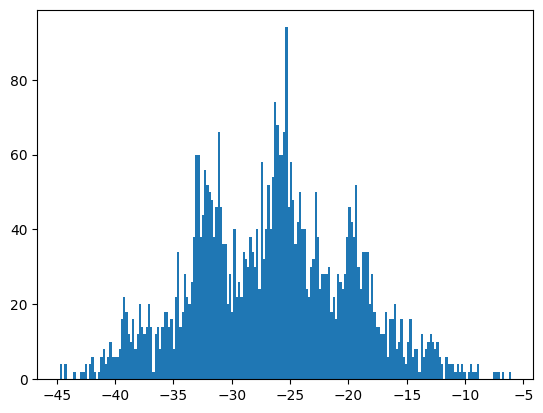

[ 4  0  4  0  0  0  2  0  0  2  2  4  0  4  6  2  0  2  6  8  4  6 10  6
  6  6  8 16 22 18 12 10 16  8 12 20 14 12 14 20 14  2 12 14  8 14 18 18
 14 16  8 22 34 14 18 28 22 20 26 38 60 60 38 44 56 52 50 48 38 46 66 46
 36 36 20 28 18 40 22 26 22 34 32 30 38 34 30 40 24 58 32 40 52 40 54 74
 68 60 60 66 94 46 58 48 36 42 50 40 40 24 22 30 32 50 38 24 28 28 28 30
 18 22 16 28 26 24 28 38 46 42 38 52 30 24 34 34 34 20 28 18 14 14 12 12
 18  6 16 16 20  8 10 16  6  4 10 16  6  8  8  2 12  6  8 10 12 10  8 10
  6  4  0  6  4  4  4  2  4  2  4  2  0  2  4  2  2  4  0  0  0  0  0  0
  2  2  2  0  2  0  0  2]
[-44.72744127 -44.53418026 -44.34091926 -44.14765825 -43.95439724
 -43.76113624 -43.56787523 -43.37461423 -43.18135322 -42.98809221
 -42.79483121 -42.6015702  -42.40830919 -42.21504819 -42.02178718
 -41.82852617 -41.63526517 -41.44200416 -41.24874316 -41.05548215
 -40.86222114 -40.66896014 -40.47569913 -40.28243812 -40.08917712
 -39.89591611 -39.7026551  -39.5093941  -39.31613309 -39.122

In [8]:
bins=200
_=plt.hist(hamiltonian_rr.diagonal(),bins=bins)
plt.show()

hist_diag_hamiltonian_rr,range_energies_rr=np.histogram(hamiltonian_rr.diagonal(),bins=bins)
print(hist_diag_hamiltonian_rr)
print(range_energies_rr)
probability_distribution_diag_hamiltonian_rr=hist_diag_hamiltonian_rr/np.sum(hist_diag_hamiltonian_rr)

#### Investigate the magnitude of $H_{QR}$

In [7]:
for q_index in range(2):
    for r_index in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr[q_index,r_index])
            idx_q=np.nonzero(QPC.quasiparticle_basis[q_index])[0]
            indices=[]
            quasiparticle_element_in_full_basis=np.zeros_like(QPC.rest_basis[r_index])
            for qi0 in idx_q:
                indices.append(QPC.couples[qi0][0])
                indices.append(QPC.couples[qi0][1])
            print(indices)
            quasiparticle_element_in_full_basis[indices]=1
            print(np.sum(np.abs(quasiparticle_element_in_full_basis-QPC.rest_basis[r_index])))
            print('\n')

q_index= 0  r_index= 0  value= -0.30779692951934234
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 5  value= 0.5106312858160081
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 6  value= 0.21613933262539425
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 9  value= 0.5755836505313379
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 16  value= 0.062155239113214744
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 20  value= 0.20328479938540367
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 21  value= -0.5082840208321852
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 22  value= 0.1894946496437248
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 23  value= 0.5082840208321852
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 24  value= 0.18949464964372487
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 25  value= 0.203284799385

Plot the Quasiparticle Hamiltonian

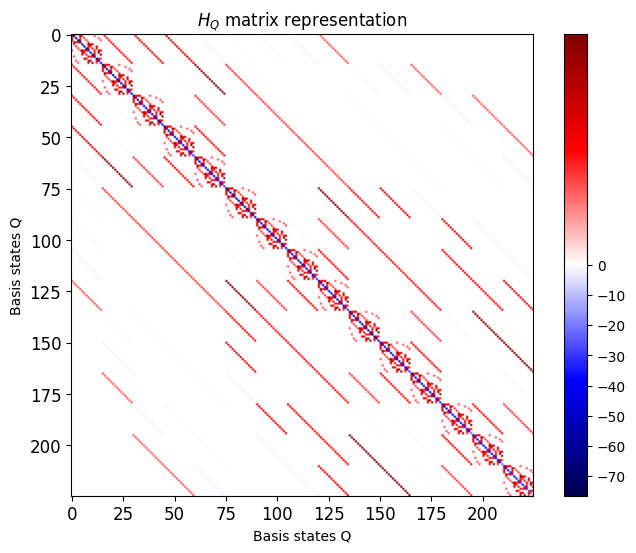

In [9]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [13]:
print(QPC.couples)

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]


### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp/np framework

#### Imports

In [112]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverter
from typing import List
from scipy.sparse import lil_matrix

# new quasiparticle class
class QuasiParticlesConverterNP():
    
    def __init__(self,):
        pass
    
    def initialize_shell(self,state_encoding:List):
        
        #### nn and pp
        couples=[]
        for a,state_a in enumerate(state_encoding):
            for b,state_b in enumerate(state_encoding):
                
                if b>a:
                    _,_,ja,ma,_,tza=state_a
                    _,_,jb,mb,_,tzb=state_b
                    if ja==jb and ma==-mb and tza==tzb:
                        couples.append([a,b])
                        
        for a,state_a in enumerate(state_encoding):
            for b,state_b in enumerate(state_encoding):
                
                if b>a:
                    _,_,ja,ma,_,tza=state_a
                    _,_,jb,mb,_,tzb=state_b
                    if ja==jb and ma==-mb and tza==-tzb:
                        couples.append([a,b])
            
        self.couples=couples



    def new_base_computation(self,base:np.ndarray):
        
        indices=np.nonzero(base)[0]
        new_base=np.zeros(len(self.couples))
        value=np.sum(base)
    
                
        list_of_token_indices=[]
        
        for i in range(new_base.shape[0]):
            
            if base[self.couples[i][0]]+base[self.couples[i][1]]!=2 :
                continue
            else:
                new_base[i]+=1
                base[self.couples[i][0]]=0
                base[self.couples[i][1]]=0
        
        new_new_base=np.zeros_like(new_base)
        idxs=np.nonzero(new_base)[0].tolist()
        size_a=len(base)//2
        for i in range(size_a):
            # this condition holds only if there is a double occupancy in these modes
            if (size_a+i in idxs) and (size_a+1+i in idxs):
                # we remove the np couple with +m and -m
                idxs.remove(size_a+i)
                # we remove the other np couple with -m and +m
                idxs.remove(size_a+1+i)
                # we add the nn +m and -m
                idxs.append(i)
                # we add the pp +m and -m
                idxs.append(i+size_a//2)
        new_new_base[idxs]=1
        if np.sum(new_new_base)==value//2:
            return new_new_base
        
        
        

    def get_the_basis_matrix_transformation(self,basis:np.ndarray):
        
        self.quasiparticle_basis=[]
        self.rest_basis=[]
        for i,b in enumerate(basis.copy()):
            qp_base=self.new_base_computation(base=b)
            if qp_base is not(None) :
                        self.quasiparticle_basis.append(qp_base)
            else:
                self.rest_basis.append(b)
        self.rest_basis=np.asarray(self.rest_basis)
        self.quasiparticle_basis=np.asarray(self.quasiparticle_basis)
        self.particles2quasiparticles=lil_matrix((len(self.quasiparticle_basis),basis.shape[0]))
        self.particles2restofstates=lil_matrix((self.rest_basis.shape[0],basis.shape[0]))
        qp_idx=0
        rest_idx=0
        for i,b in enumerate(basis.copy()):
            qp_base=self.new_base_computation(base=b)
            if qp_base is not(None):
                self.particles2quasiparticles[qp_idx,i]=1.
                qp_idx+=1
                
            else:
                self.particles2restofstates[rest_idx,i]=1
                rest_idx+=1

            
        
        

#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [78]:
file_name='data/usdb.nat' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Set the specific nucleus

In [113]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=4
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{20}$Ne'



Compute the NSM Hamiltonian

In [114]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:17<00:00, 933.56it/s]


✅ Two-body operator built: shape=(28503, 28503), nnz=6030191
[-92.77520307 -91.11503787 -88.47719024]
(28503, 28503)


Plot the NSM Hamiltonian

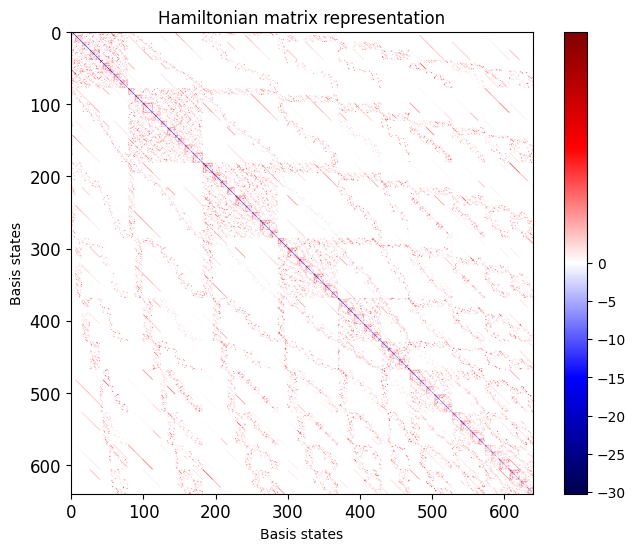

In [106]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In this case, there is a redundency of many-body basis, because the slater determinant $|100100>_n |100100>_p$ can be done in two different ways. This is already implemented in the effective many-body basis

In [123]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterNP()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis.copy())

# check the basis reduction
print(QPC.quasiparticle_basis)


print(QPC.particles2quasiparticles)

[[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<List of Lists sparse matrix of dtype 'float64'
	with 1382 stored elements and shape (1382, 28503)>
  Coords	Values
  (0, 1)	1.0
  (1, 14)	1.0
  (2, 17)	1.0
  (3, 18)	1.0
  (4, 25)	1.0
  (5, 45)	1.0
  (6, 48)	1.0
  (7, 49)	1.0
  (8, 63)	1.0
  (9, 97)	1.0
  (10, 100)	1.0
  (11, 101)	1.0
  (12, 124)	1.0
  (13, 139)	1.0
  (14, 156)	1.0
  (15, 161)	1.0
  (16, 176)	1.0
  (17, 209)	1.0
  (18, 237)	1.0
  (19, 259)	1.0
  (20, 262)	1.0
  (21, 263)	1.0
  (22, 291)	1.0
  (23, 329)	1.0
  (24, 332)	1.0
  :	:
  (1357, 28259)	1.0
  (1358, 28287)	1.0
  (1359, 28313)	1.0
  (1360, 28334)	1.0
  (1361, 28344)	1.0
  (1362, 28360)	1.0
  (1363, 28388)	1.0
  (1364, 28406)	1.0
  (1365, 28413)	1.0
  (1366, 28421)	1.0
  (1367, 28422)	1.0
  (1368, 28424)	1.0
  (1369, 28438)	1.0
  (1370, 28441)	1.0
  (1371, 28442)	1.0
  (1372, 28444)	1.0
  (1373, 28458)	1.0
  (

In [129]:
print(QPC.couples)
print(QPC.rest_basis.shape)

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22], [0, 17], [1, 16], [2, 15], [3, 14], [4, 13], [5, 12], [6, 19], [7, 18], [8, 23], [9, 22], [10, 21], [11, 20]]
(27121, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [124]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

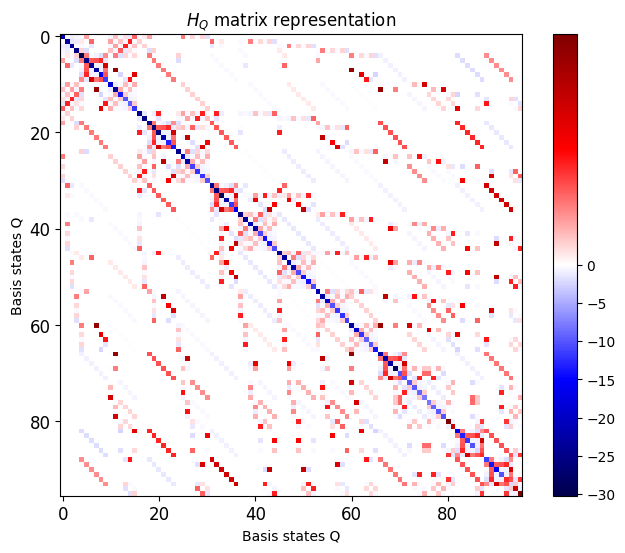

In [110]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [186]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11], [0, 9], [1, 8], [2, 7], [3, 6], [4, 11], [5, 10]]


In [187]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.6685393258426966


### Exact Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [11]:
target_eigenvalue=0
nsteps_iteration=100
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
e_old=200
# we fix the delta_e_iteration to enter the while loop
delta_e_iteration=1.0

approximations=[]
print('h_qq value=',e)
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        #diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        #single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
#for i in trange(nsteps_iteration):
i=0 # we want to count the number of iterations
while(delta_e_iteration>1e-3):    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    hamiltonian_tot_qq_full_bw=hamiltonian_qq+delta_hamiltonian
    # compute the energy for this order
    e=values[0]
    # compute the energy difference
    delta_e_iteration=e_old-e.copy()
    # now you can update the old energy
    e_old=e.copy()
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_full_brillouinwigner_method.append(1-fidelity)
    history_errors_full_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
    i+=1
    print(f'Iteration {i}: delta_e={delta_e_iteration}')
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
n_steps_bw=i

h_qq value= -51.35245722131228


100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


Iteration 1: delta_e=251.3524572213122
Iteration 2: delta_e=1.8963720488810267
Iteration 3: delta_e=1.4800500754032768
Iteration 4: delta_e=1.0917792352993416
Iteration 5: delta_e=0.8006653731672344
Iteration 6: delta_e=0.5975414007116697
Iteration 7: delta_e=0.45607475071346926
Iteration 8: delta_e=0.3558328660897345
Iteration 9: delta_e=0.28317178553790257
Iteration 10: delta_e=0.2292682728865998
Iteration 11: delta_e=0.18839170606088373
Iteration 12: delta_e=0.1567648885213515
Iteration 13: delta_e=0.13184945641530277
Iteration 14: delta_e=0.1119050363313221
Iteration 15: delta_e=0.09571388249877799
Iteration 16: delta_e=0.082407174808111
Iteration 17: delta_e=0.07135323966011242
Iteration 18: delta_e=0.062084624717876125
Iteration 19: delta_e=0.054249551247146144
Iteration 20: delta_e=0.047579154992199335
Iteration 21: delta_e=0.04186494499904114
Iteration 22: delta_e=0.03694309992490474
Iteration 23: delta_e=0.03268331842284766
Iteration 24: delta_e=0.028980816862990366
Iteration 

#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

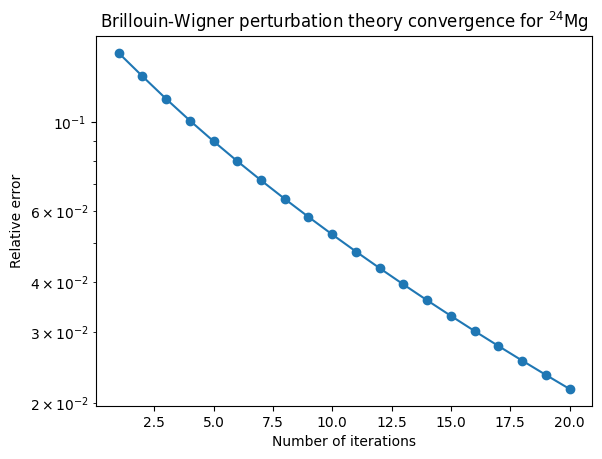

In [8]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

##### Fit of the curve

Model results (lower SSE and higher R2 are better):

power (logreg):
  params: (np.float64(0.03278869022875213), np.float64(0.8670848283195084))
  SSE=1.323e-04, R2=0.7684

exp:
  params: [0.02339407 0.15695244]
  stderr: [0.0008233  0.00736842]
  SSE=1.348e-05, R2=0.9764

stretched_exp:
  params: [0.03774317 0.34140147 0.57363698]
  stderr: [0.00112969 0.01940494 0.01476263]
  SSE=3.119e-07, R2=0.9995

power*exp:
  params: [0.02424648 0.28271811 0.09090172]
  stderr: [0.00025434 0.02049423 0.00489484]
  SSE=1.216e-06, R2=0.9979


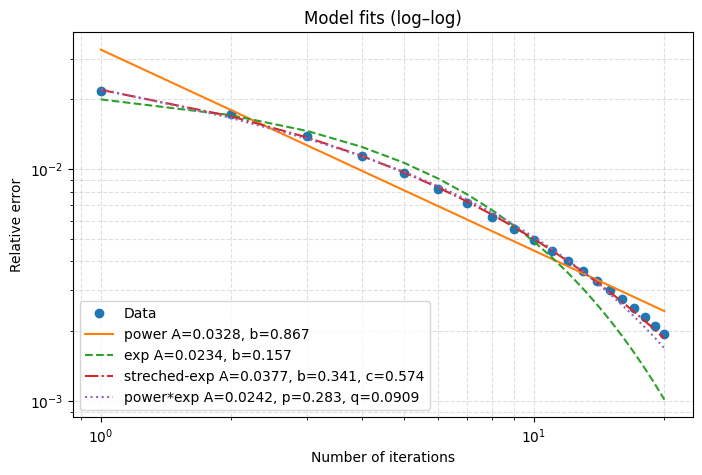

Best breakpoint (simple split) at k=4 (1-based iteration 4), total SSE=2.796e-06


In [342]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# --- data: replace with your variables ---
x = np.arange(1, nsteps_iteration + 1)
y = np.array(history_errors_full_brillouinwigner_method)

# avoid zeros or negative y when taking logs
eps = 1e-300
y = np.clip(y, eps, None)

# --- model definitions ---
def power_model(x, A, b):
    return A * x**(-b)

def exp_model(x, A, b):
    return A * np.exp(-b * x)

def stretched_exp(x, A, b, c):
    # A * exp( - (b*x)^c )
    return A * np.exp(- (b * x)**c)

def power_times_exp(x, A, p, q):
    # A * x^{-p} * exp(-q * x)
    return A * x**(-p) * np.exp(-q * x)

# --- fitting helper that wraps curve_fit with bounds and initial guesses ---
def fit_curve(model, xdata, ydata, p0=None, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(model, xdata, ydata, p0=p0, bounds=bounds, maxfev=100000)
        residuals = ydata - model(xdata, *popt)
        sse = np.sum(residuals**2)
        # R^2 on y (not on log) as a simple metric
        ss_tot = np.sum((ydata - np.mean(ydata))**2)
        r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
        return popt, np.sqrt(np.diag(pcov)), sse, r2
    except Exception as e:
        print("Fit failed for", model.__name__, ":", e)
        return None, None, np.inf, np.nan

# --- Fit models ---
results = {}

# 1) Power law: fit by linear regression on log-log (more stable)
X = np.log(x)
Y = np.log(y)
slope, intercept, rval, pval, stderr = linregress(X, Y)
b_power = -slope
A_power = np.exp(intercept)
# compute sse/r2 for consistency with other fits
y_power_pred = power_model(x, A_power, b_power)
sse_power = np.sum((y - y_power_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_power = 1 - sse_power / ss_tot
results['power (logreg)'] = ((A_power, b_power), None, sse_power, r2_power)

# 2) Exponential (nonlinear fit)
p0 = [y[0], 0.5]  # initial A and b
popt, perr, sse, r2 = fit_curve(exp_model, x, y, p0=p0, bounds=([0,0],[np.inf,np.inf]))
results['exp'] = (popt, perr, sse, r2)

# 3) Stretched exponential
# sensible initial guesses: A ~ y0, b ~ 0.5/x_mean, c ~ 1
p0 = [y[0], 0.1, 0.0]
bounds = ([0, 0, 0], [np.inf, np.inf, 5])  # restrict c to positive
popt_se, perr_se, sse_se, r2_se = fit_curve(stretched_exp, x, y, p0=p0, bounds=bounds)
results['stretched_exp'] = (popt_se, perr_se, sse_se, r2_se)

# 4) power * exponential
p0 = [y[0], 0.5, 0.1]
bounds = ([0, 0, 0], [np.inf, 5, np.inf])
popt_pe, perr_pe, sse_pe, r2_pe = fit_curve(power_times_exp, x, y, p0=p0, bounds=bounds)
results['power*exp'] = (popt_pe, perr_pe, sse_pe, r2_pe)

# --- Print results ---
print("Model results (lower SSE and higher R2 are better):")
for name, (popt, perr, sse, r2) in results.items():
    print(f"\n{name}:")
    if popt is None:
        print("  fit failed")
    else:
        print("  params:", popt)
        if perr is not None:
            print("  stderr:", perr)
        print(f"  SSE={sse:.3e}, R2={r2:.4f}")

# --- Plot data and model fits ---
plt.figure(figsize=(8,5))
plt.loglog(x, y, 'o', label='Data')

# Power-law (from logreg)
plt.loglog(x, y_power_pred, '-', label=f'power A={A_power:.3g}, b={b_power:.3g}')

# Exponential (if fit succeeded)
if results['exp'][0] is not None:
    Aexp, bexp = results['exp'][0]
    plt.loglog(x, exp_model(x, Aexp, bexp), '--', label=f'exp A={Aexp:.3g}, b={bexp:.3g}')

# Stretched exponential
if results['stretched_exp'][0] is not None:
    Ase, bse, cse = results['stretched_exp'][0]
    plt.loglog(x, stretched_exp(x, Ase, bse, cse), '-.', label=f'streched-exp A={Ase:.3g}, b={bse:.3g}, c={cse:.3g}')

# power * exp
if results['power*exp'][0] is not None:
    Ape, ppe, qpe = results['power*exp'][0]
    plt.loglog(x, power_times_exp(x, Ape, ppe, qpe), ':', label=f'power*exp A={Ape:.3g}, p={ppe:.3g}, q={qpe:.3g}')

plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title('Model fits (log–log)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# --- Optional: check for a breakpoint (simple brute-force) ---
# Try splitting the data at every candidate k and fit power-laws to left/right segments,
# pick k that minimizes total SSE.
xmin_seg = 3  # minimum points in a segment
best_k, best_sse = None, np.inf
for k in range(xmin_seg, len(x)-xmin_seg):
    # fit left (log-linear)
    xl, yl = x[:k], y[:k]
    Xl, Yl = np.log(xl), np.log(yl)
    slope_l, intercept_l, *_ = linregress(Xl, Yl)
    Al, bl = np.exp(intercept_l), -slope_l
    pred_l = power_model(xl, Al, bl)
    sse_l = np.sum((yl - pred_l)**2)
    # fit right
    xr, yr = x[k:], y[k:]
    Xr, Yr = np.log(xr), np.log(yr)
    slope_r, intercept_r, *_ = linregress(Xr, Yr)
    Ar, br = np.exp(intercept_r), -slope_r
    pred_r = power_model(xr, Ar, br)
    sse_r = np.sum((yr - pred_r)**2)
    if sse_l + sse_r < best_sse:
        best_sse = sse_l + sse_r
        best_k = k

print(f"Best breakpoint (simple split) at k={best_k} (1-based iteration {best_k}), total SSE={best_sse:.3e}")


##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

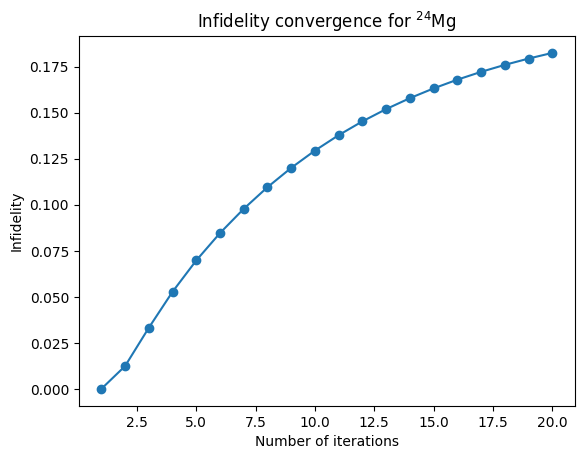

In [9]:
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [18]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_full_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.68529103]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_full_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [ ]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b)
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

### Brillouin-Wigner method with mean field approximation of $H_{RR}$

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [175]:
target_eigenvalue=0
nsteps_iteration=100
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
# hyperparameter to control the convergence
delta_e_iteration=1.0
e_old=200

approximations_meanfield=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations_meanfield.append(update)  # Store result
    
history_errors_meanfield_brillouinwigner_method=[]
interaction_terms_meanfield_brillouinwigner_method=[]
infidelities_meanfield_brillouinwigner_method=[]
i=0 # we need this index for the BW loop
#for i in trange(nsteps_iteration):
while(delta_e_iteration>1e-3):
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_meanfield[j]/e**(j+1)
    interaction_terms_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    # the same update as before
    delta_e_iteration=e_old-e.copy()
    e_old=e.copy()
    ###
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
    i+=1
    print(f'Iteration {i}: delta_e={delta_e_iteration}')
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
n_steps_bw_meanfield=i

100%|██████████| 100/100 [00:00<00:00, 1955.38it/s]


Iteration 1: delta_e=467.8088432300391
Iteration 2: delta_e=0.1539437071423322
Iteration 3: delta_e=0.14633802140713215
Iteration 4: delta_e=0.1387538075006205
Iteration 5: delta_e=0.13126153639530003
Iteration 6: delta_e=0.12392182613007208
Iteration 7: delta_e=0.11678491790058843
Iteration 8: delta_e=0.10989076279827259
Iteration 9: delta_e=0.10326957130894243
Iteration 10: delta_e=0.09694267873322815
Iteration 11: delta_e=0.09092359546127682
Iteration 12: delta_e=0.08521913468803177
Iteration 13: delta_e=0.07983053624741387
Iteration 14: delta_e=0.07475452990371423
Iteration 15: delta_e=0.06998430269351275
Iteration 16: delta_e=0.06551035180615372
Iteration 17: delta_e=0.0613212169982944
Iteration 18: delta_e=0.057404095207630235
Iteration 19: delta_e=0.05374534552123578
Iteration 20: delta_e=0.05033089569320737
Iteration 21: delta_e=0.04714656270709838
Iteration 22: delta_e=0.044178299966972645
Iteration 23: delta_e=0.04141238306658579
Iteration 24: delta_e=0.038835544977928294
Ite

#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

NameError: name 'history_errors_full_brillouinwigner_method' is not defined

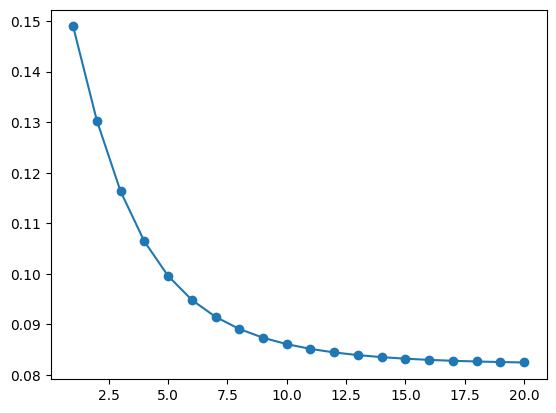

In [21]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')

plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

NameError: name 'infidelities_full_brillouinwigner_method' is not defined

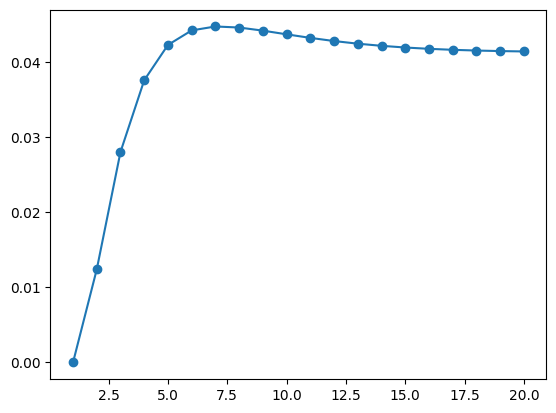

In [22]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [24]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_meanfield_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [24]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

225 1800 7048 0 0


### Brillouin-Wigner method with mean field UNIFORM approximation of $H_{RR}$ (Deprecated)

#### Initialize the uniform mean field $H_{RR}$ matrix

In [18]:
from scipy.sparse import lil_matrix,identity
hamiltonian_mfhf=np.average(hamiltonian_rr.diagonal())*identity(QPC.rest_basis.shape[0])


    

Now, let's try to compute the correction using this effective diagonal Hamiltonian and lets see what Happens.

In [19]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_mfhf
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_uniform_brillouinwigner_method=[]
interaction_terms_meanfield_uniform_brillouinwigner_method=[]
infidelities_meanfield_uniform_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_uniform_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_uniform_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_uniform_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 181.45it/s]

-82.81898591992571
0.10731549836038697 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

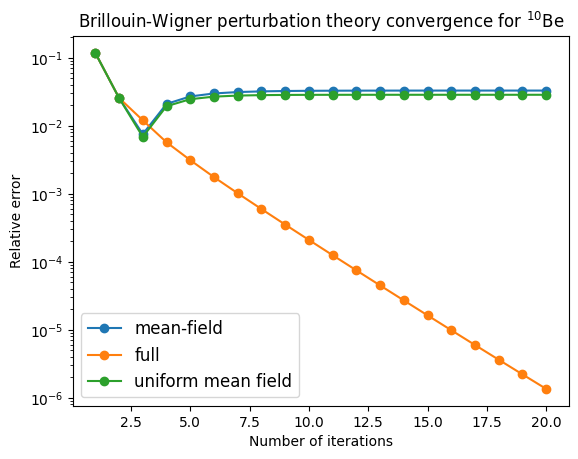

In [19]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

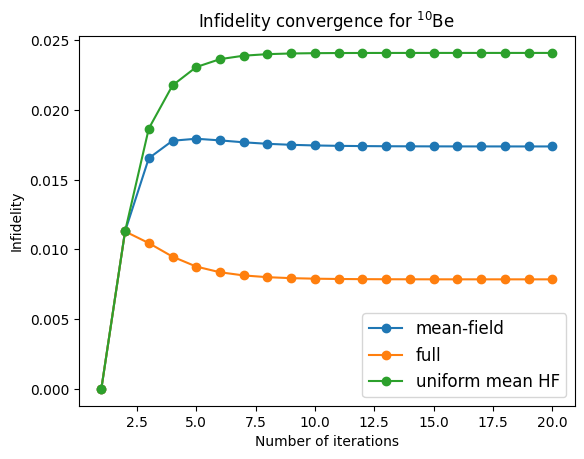

In [20]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean HF')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [20]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


Let's look at the structure of the Quasiparticle Hamiltonian

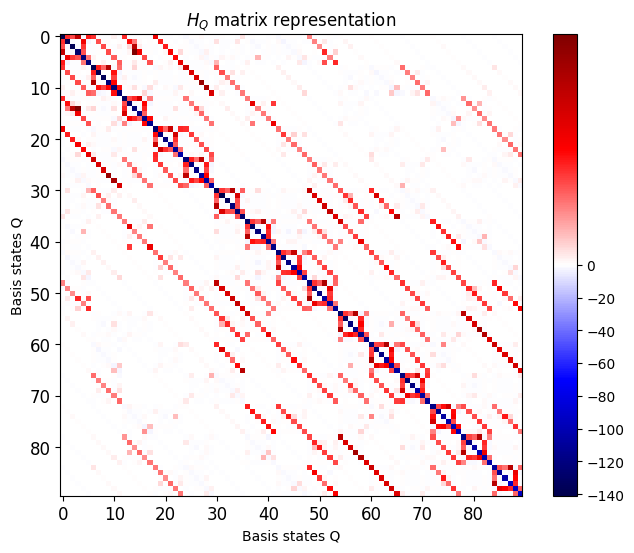

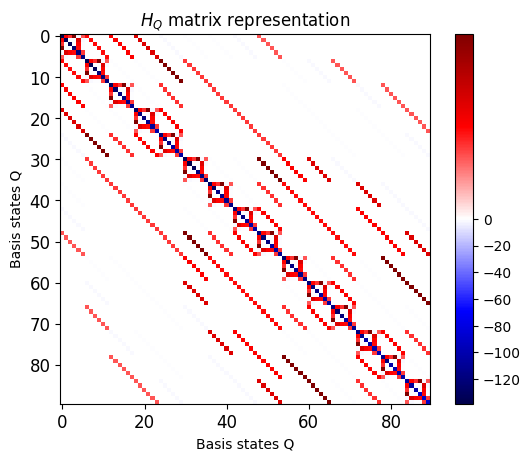

In [21]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()+ interaction_terms_meanfield_uniform_brillouinwigner_method[-1].toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

##### Plot the evolution of each element in the Hamiltonian

In [22]:
elements_vs_t=[]
index=[]
for a in range(hamiltonian_qq.shape[0]):
    for b in range(a,hamiltonian_qq.shape[0]):
        index.append([a,b])
        element=[]
        for t in range(nsteps_iteration):
            if t==0:
                element.append(hamiltonian_qq[a,b])
            else:
                element.append(hamiltonian_qq[a,b]+interaction_terms_meanfield_uniform_brillouinwigner_method[t][a,b])
        elements_vs_t.append(np.asarray(element))

elements_vs_t=np.asarray(elements_vs_t)                

In [ ]:
print(elements_vs_t.shape)
for i,a in enumerate(elements_vs_t):
    if np.abs(a[-1]-a[0])>0.1:
        print(index[i])
        plt.plot(np.arange(nsteps_iteration),a)
        plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method (Deprecated)

#### Imports

In [185]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [186]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [187]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19795.53it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [188]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [189]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T



#### Investigate the magnitude of $H_{QR}$

We can check that the magnitude of the couplings of the $H_{QR}$ is similar to the $H_{QR}$ of a generic many-body hamiltonian. Maybe it's important to check the connectivity to figure out if more or less we can reduce it randomly or not.

In [190]:
count=0
for q_index in range(hamiltonian_qr_2b.shape[0]):
    for r_index in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,r_index]!=0:
            # print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr_2b[q_index,r_index])
            # print('\n')
            count+=1

print(count)

2555


In [165]:
print(hamiltonian_qr.shape,hamiltonian_qr_2b.shape)

(225, 28278) (36, 604)


In [191]:
print((1-2/12)*(1-2/12))
print((1-4/12)*(1-4/12))
print((1-4/12)*(1-4/12))



0.6944444444444445
0.44444444444444453
0.44444444444444453


In [ ]:
for q_index in range(QPC.quasiparticle_basis.shape[0]):
    count=0
    for line in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,line]!=0:
            count+=1
    print(count)

    count2=0
    for line in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,line]!=0:
            count2+=1
    print(count2)
    
    print('ratio=',count2/count)





In [ ]:
print(hamiltonian_qr_2b)

#### Create the two-body corrections using the sampled reconstruction of the $H_{RR}$ mean field term and keeping the off diagonal transition of the two-body $H_{RR}$. 

In [199]:
print(range_energies_rr.shape,probability_distribution_diag_hamiltonian_rr.shape)
new_diagonal_contribution=np.random.choice(range_energies_rr[:-1],size=hamiltonian_rr_2b.shape[0],p=probability_distribution_diag_hamiltonian_rr)

#delta_energy_samples=np.max(hamiltonian_rr.diagonal())-hamiltonian_rr.diagonal()
#delta_energy_samples=hamiltonian_rr.diagonal()-np.min(hamiltonian_rr.diagonal())

#p_energy=delta_energy_samples/np.sum(delta_energy_samples)

#new_diagonal_contribution=np.random.choice(hamiltonian_rr.diagonal(),size=hamiltonian_rr_2b.shape[0],p=p_energy)

(201,) (200,)


In [200]:
from scipy.sparse import lil_matrix
#hamiltonian_rr_2body=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))


# in order to take into account of the extensive magnitude of the energy
for r in range(hamiltonian_rr_2b.shape[0]):
    #gamma=np.random.normal(0,np.std(hamiltonian_rr.diagonal()))
    hamiltonian_rr_2b[r,r]=new_diagonal_contribution[r]#(hamiltonian_rr_2b[r,r]-mean_2b_hamiltonian_rr)*(np.average(hamiltonian_rr.diagonal()))/(mean_2b_hamiltonian_rr)

    
    print(hamiltonian_rr_2b[r,r])
    print(hamiltonian_rr[r,r],'\n')

-91.01404130148813
-106.22944384920635 

-101.49077738809528
-101.20254408730167 

-81.34320799077383
-98.07438319444441 

-87.79043019791669
-109.11239057539684 

-83.22364780119051
-108.0196628968254 

-79.46276818035717
-106.16699182539682 

-87.2531616806548
-107.97626414682549 

-95.58082369821432
-101.26191583333329 

-95.04355518095241
-99.26916422619044 

-86.98452742202385
-100.6766113492063 

-80.80593947351193
-100.53653081349208 

-91.28267556011909
-96.25922438492066 

-88.05906445654765
-94.55793089285712 

-94.77492092232146
-99.56158722222216 

-69.79193486964289
-102.46556198412691 

-93.70038388779766
-99.39556859126978 

-96.65536073273813
-95.22799323412698 

-103.37121719851194
-97.9639746031746 

-80.53730521488097
-96.36848033730166 

-88.8649672324405
-92.43197700396823 

-96.38672647410718
-89.05103015873014 

-82.6863792839286
-91.0171603769841 

-96.38672647410718
-91.80378888888886 

-91.55130981875004
-85.61934444444438 

-101.49077738809528
-107.4555525992

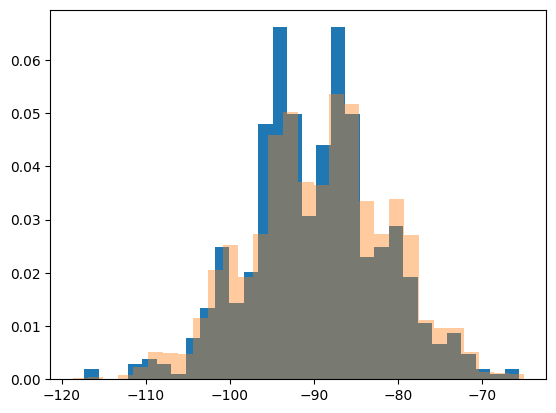

In [201]:
plt.hist(hamiltonian_rr_2b.diagonal(),bins=30,density=True)
plt.hist(hamiltonian_rr.diagonal(),bins=30,alpha=0.4,density=True)
plt.show()

In [ ]:
for i in range(hamiltonian_qr_2b.shape[0]):
    for j in range(hamiltonian_qr_2b.shape[1]):
        print('i,j',i,j)
        print(hamiltonian_qr_2b[i,j])
        print(hamiltonian_qr[i,j])
        print('\n')

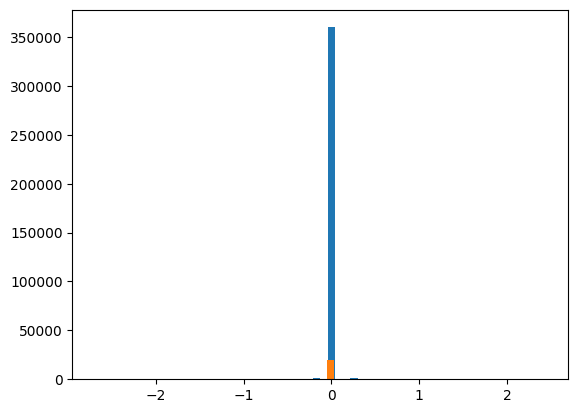

In [144]:
plt.hist(hamiltonian_qr.toarray().flatten(),bins=60)
plt.hist(hamiltonian_qr_2b.toarray().flatten(),bins=60)
plt.show()

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [202]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            
            if (q_max == p_max ) and (q_min == p_min) :
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a*nparticles_b/4)

            elif (q_max==p_max) and (q_min!=p_min) and (q_max < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_max==p_max) and (q_min!=p_min) and (q_max > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            else:
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


100%|██████████| 20/20 [00:00<00:00, 27.91it/s]


#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [203]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [204]:
from tqdm import tqdm

approximations_truncated=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=((1-nparticles_a/size_a)*(1-nparticles_b/size_b))/((1-2/12)*(1-2/12))*HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated.append(operator)    

100%|██████████| 1296/1296 [00:00<00:00, 5302.91it/s]
20it [00:05,  3.93it/s]


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [ ]:
for i in range(approximations_meanfield[0].shape[0]):
    for j in range(approximations_meanfield[0].shape[0]):
        if approximations_meanfield[0][i,j]!=0:
            print('ij=',i,j)
            print(approximations_meanfield[0][i,j])
            print(approximations_truncated[0][i,j])
            print('\n')

In [206]:
print(approximations_truncated[0])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15281 stored elements and shape (225, 225)>
  Coords	Values
  (0, 0)	67.42584294007733
  (0, 1)	2.0786867100529838
  (0, 2)	-0.9665363781487761
  (0, 3)	2.279254821062709
  (0, 4)	-1.2855557078714979
  (0, 6)	-4.141994918155913
  (0, 7)	3.2530805524395645
  (0, 10)	5.720407205518891
  (0, 11)	-1.8097149447787118
  (0, 15)	-3.424231242706855
  (0, 16)	-0.09678531717170237
  (0, 17)	0.022611208231790744
  (0, 18)	-0.02322649057496184
  (0, 19)	0.5662579318312961
  (0, 22)	-1.1154236526947232
  (0, 25)	-0.2619818929142366
  (0, 26)	0.13090102528160788
  (0, 30)	-4.668530756443733
  (0, 31)	-0.9071040432000004
  (0, 32)	1.3606560648000003
  (0, 33)	-0.08866831905920297
  (0, 34)	0.02817178672365412
  (0, 37)	-0.003024951740952386
  (0, 40)	-0.023993766433139094
  (0, 41)	0.06587543310971807
  :	:
  (224, 178)	-0.02322649057496183
  (224, 179)	2.230593132007212
  (224, 187)	-0.010010843842963517
  (224, 190)	-0.000599695360000000

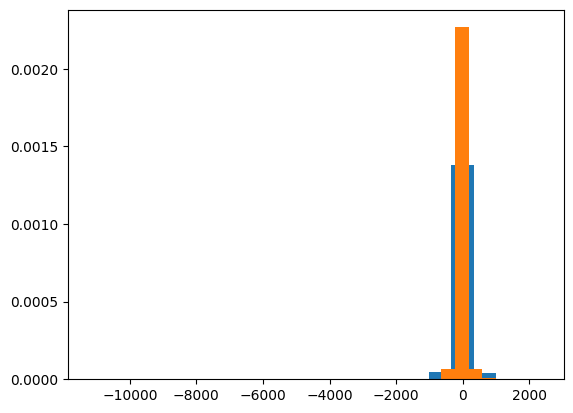

In [207]:

# we select an iteration term
idx_iteration=1
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=20,density=True)
_=plt.hist(approximations_truncated[idx_iteration].toarray().flatten(),bins=20,density=True)


#### Now we compute the iteration using this truncation, good luck

In [208]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_brillouinwigner_method=[]
interaction_terms_truncated_brillouinwigner_method=[]
infidelities_truncated_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated[j]/e**(j+1)
    interaction_terms_truncated_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 300.05it/s]

-128.38215664694954
0.030179143298433835 index= 19


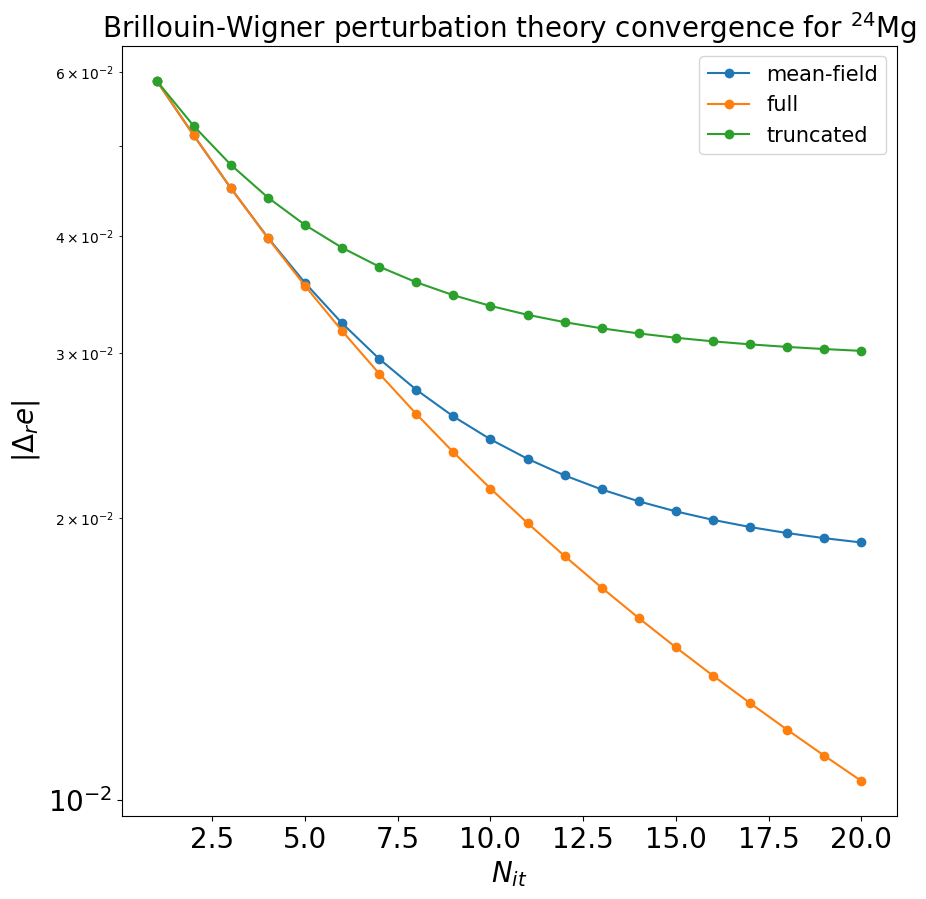

In [210]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)
plt.show()

### Brillouin-Wigner-Inspired Method for extract effective-quasiparticle-two-body interactions 

#### Imports

In [ ]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp
from src.hartree_fock_library import HFEnergyFunctionalNuclear,build_fock_matrix
import torch.optim as optim

#### First, we need to solve the Hartree-Fock optimization for the nucleus, to extract the HF Energy and the density

In [ ]:
import torch
import numpy as np
import random

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# we compute the m values array
m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)


# we initialize the Hartree-Fock model as a pytorch module
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

E1: -11.191885240772244, E2: -19.062640963572697, E_constrain: 0.0
Step    0 | Energy = -30.254526
E1: -11.434325540091587, E2: -19.174060499049187, E_constrain: 0.0
E1: -11.678422323019388, E2: -19.284562706483932, E_constrain: 0.0
E1: -11.922355484558766, E2: -19.395569360869665, E_constrain: 0.0
E1: -12.164756054097875, E2: -19.50829558044888, E_constrain: 0.0
E1: -12.40545700199755, E2: -19.62263307678774, E_constrain: 0.0
E1: -12.644474424234442, E2: -19.73812662865621, E_constrain: 0.0
E1: -12.881624614366128, E2: -19.854545279521496, E_constrain: 0.0
E1: -13.116688838047367, E2: -19.971743739897803, E_constrain: 0.0
E1: -13.349439008467419, E2: -20.089630021627983, E_constrain: 0.0
E1: -13.579611746612823, E2: -20.208214344704675, E_constrain: 0.0
E1: -13.806927816670152, E2: -20.32759994700665, E_constrain: 0.0
E1: -14.031133641262446, E2: -20.447920098441834, E_constrain: 0.0
E1: -14.252035519548812, E2: -20.569265640486368, E_constrain: 0.0
E1: -14.46951639104305, E2: -20.691

In [ ]:
print(model.rho_n.shape,model.rho_n.diagonal().sum())
print(model.rho_p.shape,model.rho_p.diagonal().sum())
plt.plot(model.rho_n.diagonal().detach().numpy())
plt.plot(model.rho_p.diagonal().detach().numpy())
plt.show()

full_rho=np.zeros((2*model.rho_n.shape[0],2*model.rho_n.shape[0]))

full_rho=model.rho_n.detach().numpy()+model.rho_p.detach().numpy()

full_density_hf=np.zeros((size_a+size_b))
full_density_hf[:size_a]=model.rho_n.diagonal().detach().numpy()[:size_a]
full_density_hf[size_a:]=model.rho_p.diagonal().detach().numpy()[size_a:]

print(model())

energy_hf=model().item()

print(energy_hf)

# symmetric configuration with m=0
symmetric_m_array=np.array([5,4,3,2,1,0,7,6,11,10,9,8])
symmetric_m_array=np.concatenate([symmetric_m_array,symmetric_m_array+size_a])

full_density_hf=0.5*(full_density_hf[symmetric_m_array].copy()+full_density_hf.copy())

plt.plot(full_density_hf)
plt.show()


#### considering the HF-part of the spectrum forcing the rotational symmetry |||

F_n,F_p=model.build_fock_matrices_factorized()


        

#### Build HF density matrix in the 4 particle subspace

In [ ]:
import torch
import numpy as np
import random

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# we compute the m values array
m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)


# we initialize the Hartree-Fock model as a pytorch module
model_twobody=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=2,num_protons=2,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model_twobody.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy_twobody = model_twobody()  # calls forward()
    energy_twobody.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy_twobody.item():.6f}")

In [323]:
psi_hf_nsm=np.zeros(NSMHamiltonian.basis.shape[0])

for idx_rb,rb in enumerate(NSMHamiltonian.basis):
    occ_idx=np.nonzero(rb)[0]
    proton_idxs=occ_idx[occ_idx >= size_a]
    neutron_idxs=occ_idx[occ_idx < size_a]
    phi_neutron=model.hf_component_from_indices(occ_idx=neutron_idxs,species='neutron')
    phi_proton=model.hf_component_from_indices(occ_idx=proton_idxs,species='proton')
    psi_hf_nsm[idx_rb]=phi_neutron*phi_proton
    # normalization factor
psi_hf_nsm=psi_hf_nsm/np.linalg.norm(psi_hf_nsm)

print(psi_hf_nsm.conj() @ NSMHamiltonian.hamiltonian @ psi_hf_nsm)
#energy_hf=psi_hf_nsm.conj() @ NSMHamiltonian.hamiltonian @ psi_hf_nsm



-56.6023006757383


In [ ]:
from scipy.sparse import csr_matrix
import math

psi_hf=np.zeros(Hamiltonian2bodysector.basis.shape[0])

for idx_rb,rb in enumerate(Hamiltonian2bodysector.basis):
    occ_idx=np.nonzero(rb)[0]
    proton_idxs=occ_idx[occ_idx >= size_a]
    neutron_idxs=occ_idx[occ_idx < size_a]
    print(occ_idx)
    print(neutron_idxs)
    phi_neutron=model_twobody.hf_component_from_indices(occ_idx=neutron_idxs,species='neutron')
    phi_proton=model_twobody.hf_component_from_indices(occ_idx=proton_idxs,species='proton')
    psi_hf[idx_rb]=phi_neutron*phi_proton
    # normalization factor
    print(math.comb(nparticles_a,2))
psi_hf=psi_hf/np.linalg.norm(psi_hf)
print(psi_hf.shape)


density_matrix = csr_matrix(np.einsum('a,b->ab',psi_hf,psi_hf.conj()))
print(density_matrix)


density_matrix_rr=QPC2body.particles2restofstates @ density_matrix @ QPC2body.particles2restofstates.T

#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [298]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [299]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19425.40it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

##### Here we use only the nn/pp quasiparticle approach

In [303]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


##### Here we use the nn/pp + np/pn approach

In [301]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterNP()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis.copy())


##### Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [304]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T

energy_scale,_=eigsh(hamiltonian_rr,k=5,which='SA')
print(energy_scale)


[-55.99608892 -54.74906964 -54.18720967 -54.18397053 -54.16393042]


##### Fully HF method

In [305]:
print(SPS.energies)

lambd_n,_=np.linalg.eigh(F_n.detach().numpy())
lambd_p,_=np.linalg.eigh(F_p.detach().numpy())

# perform an ordering following the m symmetry 
m_corrispondence_index=np.array([0,5,1,4,2,3,6,7,8,11,9,10])

new_lambd_n=np.zeros_like(lambd_n)
new_lambd_p=np.zeros_like(lambd_p)

for i in range(0,size_a,2):
    new_lambd_n[m_corrispondence_index[i:i+2]]=lambd_n[i:i+2]
    new_lambd_p[m_corrispondence_index[i:i+2]]=lambd_p[i:i+2]
print(np.sum(lambd_p[:2]))
print(np.sum(lambd_n[:10]))

print(new_lambd_n)

[-3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.2079 -3.2079  2.1117
  2.1117  2.1117  2.1117 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257
 -3.2079 -3.2079  2.1117  2.1117  2.1117  2.1117]
-22.516715038129806
-53.18288528077375
[-9.96997473 -6.79859759 -4.97643523 -4.97643522 -6.79859756 -9.96997463
 -4.08873288 -4.0887328  -0.75770234  1.12040376  1.12040377 -0.75770229]


In [306]:
from scipy.sparse import lil_matrix
hamiltonian_rr_2b_diagonal=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))
for idx_r,b in enumerate(QPC2body.rest_basis):
    idxs=np.nonzero(b)[0]
    indices_n=np.arange(size_a)
    indices_p=np.arange(size_b)
    energy_term_hf=0.
    for idx in idxs:
        if idx < size_a:
            energy_term_hf+=F_n[idx,idx]#new_lambd_n[idx]
            indices_n=indices_n[indices_n!=idx]
        else:
            energy_term_hf+=F_p[idx-size_a,idx-size_a]#new_lambd_p[idx-size_a]
        
            indices_p=indices_p[indices_p!=idx-size_a]
    
    print(idxs)
    print(new_lambd_n)
    for i in range(nparticles_a-2):
        
        idx=np.argmin(F_n.detach().numpy().diagonal()[indices_n])#np.argmin(new_lambd_n[indices_n])
        energy_term_hf+=F_n[indices_n[idx],indices_n[idx]]#new_lambd_n[indices_n[idx]]
        
        print(indices_n[idx])
        print(new_lambd_n[idx])
        print(indices_n)
        indices_n=indices_n[indices_n!=indices_n[idx]]
    for j in range(nparticles_b-2):
        idx=np.argmin(F_p.detach().numpy().diagonal()[indices_p])#np.argmin(new_lambd_p[indices_p])
        energy_term_hf+=F_p[indices_p[idx],indices_p[idx]]#new_lambd_p[indices_p[idx]]
        indices_p=indices_p[indices_p!=indices_p[idx]]
        print(indices_p)
        print(idx+size_a)
    
    hamiltonian_rr_2b_diagonal[idx_r,idx_r]=energy_term_hf

[ 0  1 16 17]
[-9.96997473 -6.79859759 -4.97643523 -4.97643522 -6.79859756 -9.96997463
 -4.08873288 -4.0887328  -0.75770234  1.12040376  1.12040377 -0.75770229]
3
-6.798597593757061
[ 2  3  4  5  6  7  8  9 10 11]
2
-9.969974731272867
[ 2  4  5  6  7  8  9 10 11]
[ 0  1 17 23]
[-9.96997473 -6.79859759 -4.97643523 -4.97643522 -6.79859756 -9.96997463
 -4.08873288 -4.0887328  -0.75770234  1.12040376  1.12040377 -0.75770229]
3
-6.798597593757061
[ 2  3  4  5  6  7  8  9 10 11]
2
-9.969974731272867
[ 2  4  5  6  7  8  9 10 11]
[ 0  2 15 17]
[-9.96997473 -6.79859759 -4.97643523 -4.97643522 -6.79859756 -9.96997463
 -4.08873288 -4.0887328  -0.75770234  1.12040376  1.12040377 -0.75770229]
3
-6.798597593757061
[ 1  3  4  5  6  7  8  9 10 11]
1
-9.969974731272867
[ 1  4  5  6  7  8  9 10 11]
[ 0  2 16 23]
[-9.96997473 -6.79859759 -4.97643523 -4.97643522 -6.79859756 -9.96997463
 -4.08873288 -4.0887328  -0.75770234  1.12040376  1.12040377 -0.75770229]
3
-6.798597593757061
[ 1  3  4  5  6  7  8  9 1

In [ ]:
print(hamiltonian_rr_2b_diagonal)

In [308]:
hamiltonian_rr_2b.setdiag(hamiltonian_rr_2b_diagonal.diagonal())

In [ ]:
print(hamiltonian_rr_2b)

#### Investigate the magnitude of $H_{QR}$

#### Create the two-body corrections using the Hartree fock as energy scale of the full many-body Hamiltonian in the RR basis. 

In [310]:
from scipy.sparse import lil_matrix,identity

hamiltonian_rr_2b=energy_hf*identity(QPC2body.rest_basis.shape[0])

#### Get the $H_{QR}$ and $H_{RQ}$ with the Pauli Blockade

In [311]:
from scipy.sparse import lil_matrix,identity

hamiltonian_qr_2b_pauliblockade=lil_matrix((QPC2body.quasiparticle_basis.shape[0],QPC2body.rest_basis.shape[0]))

for index_qbasis,qb in enumerate(QPC2body.quasiparticle_basis):
    quasiparticle_indices=[]
    idxs=np.nonzero(qb)[0]
    for idx in idxs:
        quasiparticle_indices.append(QPC2body.couples[idx][0])
        quasiparticle_indices.append(QPC2body.couples[idx][1])
    for index_restbasis,rb in enumerate(QPC2body.rest_basis):
        if hamiltonian_qr_2b[index_qbasis,index_restbasis]!=0:
            
            rest_indices=np.nonzero(rb)[0]
            added_indices = sorted(set(rest_indices) - set(quasiparticle_indices))  # added
            removed_indices=sorted(set(quasiparticle_indices) - set(rest_indices))
            pauli_blocking_vector_added=((1-full_density_hf[added_indices]))
            pauli_blocking_vector_removed=(full_density_hf[removed_indices])
            hamiltonian_qr_2b_pauliblockade[index_qbasis,index_restbasis]=np.prod(pauli_blocking_vector_added)*hamiltonian_qr_2b[index_qbasis,index_restbasis]
            #hamiltonian_rq_2b_pauliblockade[index_restbasis,index_qbasis]=np.prod(pauli_blocking_vector_removed)*hamiltonian_rq_2b[index_restbasis,index_qbasis]
            
hamiltonian_rq_2b_pauliblockade=hamiltonian_qr_2b_pauliblockade.T

##### Pauli Blockade for the off diagonal H_rr

In [312]:
from scipy.sparse import lil_matrix,identity

mask_pauliblockade=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))


for index_rbasis_a,rba in enumerate(QPC2body.rest_basis):
    quasiparticle_indices=[]
    rest_indices_a=np.nonzero(rba)[0]
    for index_restbasis_b,rbb in enumerate(QPC2body.rest_basis):
        if hamiltonian_rr_2b[index_rbasis_a,index_restbasis_b]!=0 and index_restbasis_b!=index_rbasis_a:
            
            rest_indices_b=np.nonzero(rbb)[0]
            added_indices = sorted(set(rest_indices_b) - set(rest_indices_a))  # added
            removed_indices=sorted(set(rest_indices_a) - set(rest_indices_b))
            pauli_blocking_vector_added=((1-full_density_hf[added_indices]))
            pauli_blocking_vector_removed=(full_density_hf[removed_indices])
            mask_pauliblockade[index_rbasis_a,index_restbasis_b]=np.prod(pauli_blocking_vector_added)
            #hamiltonian_rq_2b_pauliblockade[index_restbasis,index_qbasis]=np.prod(pauli_blocking_vector_removed)*hamiltonian_rq_2b[index_restbasis,index_qbasis]
            
mask_pauliblockade=0.5*(mask_pauliblockade+mask_pauliblockade.T)
mask_pauliblockade.setdiag(np.ones(QPC2body.rest_basis.shape[0]))

TypeError: 'dia_matrix' object is not subscriptable

In [215]:
print(mask_pauliblockade[0,1],mask_pauliblockade[1,0])

0.9576910081748611 0.9576910081748611


#### Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [313]:
print(density_matrix.shape)

(640, 640)


In [329]:
target_eigenvalue=0
nsteps_iteration_bwi=100
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b   # Start with initial term
for i in trange(nsteps_iteration_bwi):
    if i >0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    # if i> 1:
    #     diagonal_rr=hamiltonian_rr_2b @ mask_pauliblockade
    #     diagonal_rr=0.5*(diagonal_rr+diagonal_rr.T) 
    #     single_term =diagonal_rr  @ single_term  # Efficient update
        
    update=(hamiltonian_qr_2b @ density_matrix_rr  @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            

            twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


In [ ]:
for key in approximations_as_dictionary[0].keys():
    a,b,c,d=key
    if approximations_as_dictionary[0][key]!=0:
        print('key=',key)
        print(approximations_as_dictionary[0][key])
        print('\n')

#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [316]:
print(QPC.quasiparticle_basis)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [317]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)



We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [ ]:
from tqdm import tqdm

approximations_truncated_uniform=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated_uniform.append(0.5*(operator+operator.T))    

#### Analysis of the element of the BW correction with respect to the exact formulation

Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [ ]:

for i in range(QPC.quasiparticle_basis.shape[0]):
    for j in range(QPC.quasiparticle_basis.shape[0]):
        print(approximations[0][i,j],approximations_truncated_uniform[0][i,j])

In [ ]:
print(approximations_truncated_uniform[0])

In [ ]:

# we select an iteration term
idx_iteration=1
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=50)
_=plt.hist(approximations_truncated_uniform[idx_iteration].toarray().flatten(),bins=50)

#### Now we compute the iteration using this truncation, good luck

In [330]:

# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
delta_e_iteration=1.0
e_old=200
    
history_errors_truncated_uniform_meanfield_brillouinwigner_method=[]
interaction_terms_truncated_uniform_meanfield_brillouinwigner_method=[]
infidelities_truncated_uniform_meanfield_brillouinwigner_method=[]
i=0
#for i in trange(nsteps_iteration_bwi):
while((delta_e_iteration)>1e-3):    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated_uniform[j]/e**(j+1)
    interaction_terms_truncated_uniform_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi_hf=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    hamiltonian_tot_qq_hf=hamiltonian_qq+delta_hamiltonian
    #update the energy difference
    e=values[0]
    delta_e_iteration=(e_old-e)
    e_old=e.copy()
    #
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi_hf))**2
    infidelities_truncated_uniform_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_uniform_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
    print('iteration=',i,' delta_e=',delta_e_iteration,'energy=',e)
    i+=1

n_steps_bwi=i
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

iteration= 0  delta_e= 251.3524572213122 energy= -51.35245722131219
iteration= 1  delta_e= 0.3369546477832728 energy= -51.689411869095466
iteration= 2  delta_e= 0.42574186517941826 energy= -52.115153734274884
iteration= 3  delta_e= 0.5005983557012286 energy= -52.61575208997611
iteration= 4  delta_e= 0.548388003338907 energy= -53.16414009331502
iteration= 5  delta_e= 0.5632087222939148 energy= -53.727348815608934
iteration= 6  delta_e= 0.548228079510686 energy= -54.27557689511962
iteration= 7  delta_e= 0.5128594103565831 energy= -54.7884363054762
iteration= 8  delta_e= 0.4673341078758497 energy= -55.25577041335205
iteration= 9  delta_e= 0.41912725182729815 energy= -55.67489766517935
iteration= 10  delta_e= 0.37253612115744517 energy= -56.047433786336796
iteration= 11  delta_e= 0.32962346518529273 energy= -56.37705725152209
iteration= 12  delta_e= 0.29113766851517653 energy= -56.668194920037266
iteration= 13  delta_e= 0.25713232835116173 energy= -56.92532724838843
iteration= 14  delta_e=

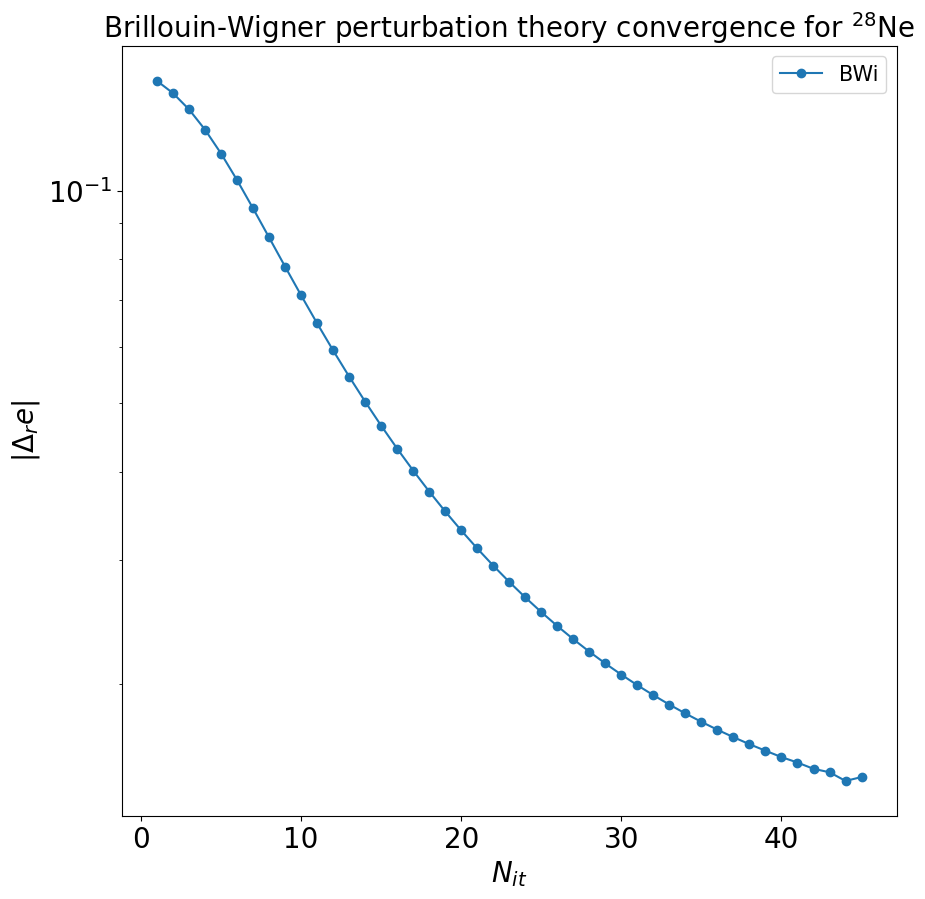

In [320]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
#plt.plot(range(1,n_steps_bw_meanfield+1),history_errors_meanfield_brillouinwigner_method,'-o',label='BW-MF')
#plt.plot(range(1,n_steps_bw+1),history_errors_full_brillouinwigner_method,'-o',label='BW')
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
#plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated ')
plt.plot(range(1,len(history_errors_truncated_uniform_meanfield_brillouinwigner_method)+1),history_errors_truncated_uniform_meanfield_brillouinwigner_method,'-o',label='BWi')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20,which='major')
plt.tick_params(labelsize=15,which='minor')

plt.legend(fontsize=15)
plt.show()

#### Accuracy with respect to the exact Brillouin-Wigner method

In [354]:
from scipy.sparse.linalg import norm
fidelity=np.abs(np.vdot(psiq_orderi_hf,psiq_orderi))**2
print(fidelity)

distance_hf=norm(hamiltonian_tot_qq_full_bw- hamiltonian_tot_qq_hf,ord='fro')/norm(hamiltonian_tot_qq_full_bw,ord='fro')

print(distance_hf)


0.7160072023808627
0.06390670084773041


### Brillouin-Wigner-Inspired Method using the 2body corrections directly

#### Imports

In [182]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp
from src.hartree_fock_library import HFEnergyFunctionalNuclear,build_fock_matrix
import torch.optim as optim

#### Compute the reduced 2-body density to get the quantities

[-78.95747726] (225, 1) 0.9999999999999997


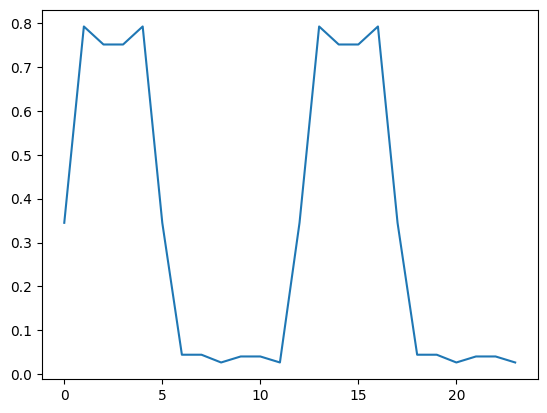

3.9999999999999973 3.9999999999999982


In [183]:


e_qq,psi_qq=eigsh(hamiltonian_qq,k=1,which='SA')
print(e_qq,psi_qq.shape,np.linalg.norm(psi_qq))
full_density_quasiparticle=np.zeros(len(QPC.couples))
full_density_hf=np.zeros(size_a+size_b)
for i in range(len(QPC.couples)):
    for index_q,qb in enumerate(QPC.quasiparticle_basis):
        
        full_density_quasiparticle[i]+=np.conj(psi_qq[index_q,0])*psi_qq[index_q,0]*qb[i]

    full_density_hf[QPC.couples[i][0]]+=full_density_quasiparticle[i]
    full_density_hf[QPC.couples[i][1]]+=full_density_quasiparticle[i]
    
plt.plot(full_density_hf)
plt.show()

print(np.sum(full_density_hf[:size_a]),np.sum(full_density_hf[size_a:]))

 
        

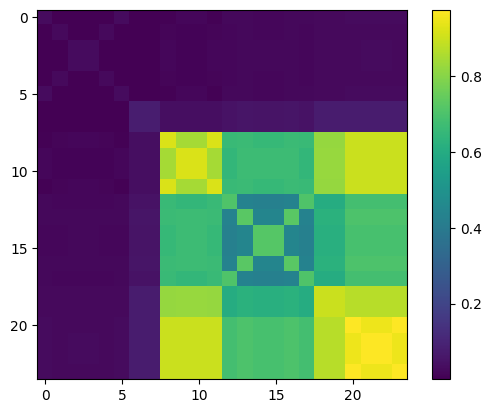

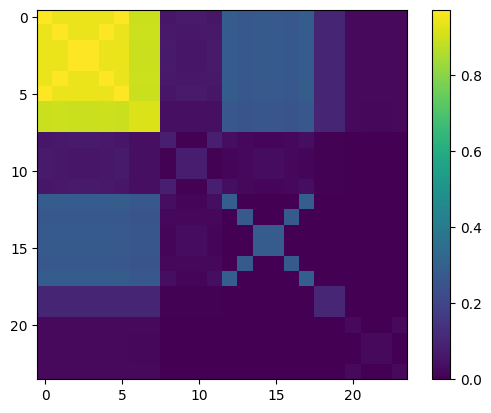

In [163]:

e_qq,psi_qq=eigsh(hamiltonian_qq,k=1,which='SA')
psi_qq_gs_full_space=QPC.particles2quasiparticles.T @ psi_qq[:,0]

psi_qq_gs_full_space/=np.linalg.norm(psi_qq_gs_full_space)

# twobody density component the vacancy prob

full_density_quasiparticle=np.zeros(len(QPC.couples))
full_density_hf=np.zeros(size_a+size_b)
rho_vacuum=np.zeros((size_a+size_b,size_a+size_b))
rho_full=np.zeros((size_a+size_b,size_a+size_b))
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        psi_mod_square=psi_qq_gs_full_space.conj()*psi_qq_gs_full_space
        value_vacuum=np.sum(psi_mod_square*(1-NSMHamiltonian.basis[:,a])*((1-NSMHamiltonian.basis[:,b])))
        value_full=np.sum(psi_mod_square*(NSMHamiltonian.basis[:,a])*((NSMHamiltonian.basis[:,b])))
        rho_vacuum[a,b]=value_vacuum
        rho_full[a,b]=value_full
    

plt.imshow(rho_vacuum)
plt.colorbar()
plt.show()

plt.imshow(rho_full)
plt.colorbar()
plt.show()

#### Build HF density matrix in the 4 particle subspace

In [164]:
import torch
import numpy as np
import random

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# we compute the m values array
m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)


# we initialize the Hartree-Fock model as a pytorch module
model_twobody=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=2,num_protons=2,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model_twobody.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy_twobody = model_twobody()  # calls forward()
    energy_twobody.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy_twobody.item():.6f}")

Step    0 | Energy = -15.341504
Step   20 | Energy = -19.632585
Step   40 | Energy = -22.060543
Step   60 | Energy = -23.950746
Step   80 | Energy = -25.644993
Step  100 | Energy = -26.861494
Step  120 | Energy = -27.687639
Step  140 | Energy = -28.402311
Step  160 | Energy = -29.407108
Step  180 | Energy = -31.078950
Step  200 | Energy = -33.145770
Step  220 | Energy = -34.905894
Step  240 | Energy = -35.992965
Step  260 | Energy = -36.555335
Step  280 | Energy = -36.839558
Step  300 | Energy = -36.989396
Step  320 | Energy = -37.072181
Step  340 | Energy = -37.119439
Step  360 | Energy = -37.146847
Step  380 | Energy = -37.162785
Step  400 | Energy = -37.171998
Step  420 | Energy = -37.177267
Step  440 | Energy = -37.180238
Step  460 | Energy = -37.181886
Step  480 | Energy = -37.182786
Step  500 | Energy = -37.183268
Step  520 | Energy = -37.183522
Step  540 | Energy = -37.183653
Step  560 | Energy = -37.183719
Step  580 | Energy = -37.183752
Step  599 | Energy = -37.183768


In [ ]:
psi_hf_nsm=np.zeros(NSMHamiltonian.basis.shape[0])

for idx_rb,rb in enumerate(NSMHamiltonian.basis):
    occ_idx=np.nonzero(rb)[0]
    proton_idxs=occ_idx[occ_idx >= size_a]
    neutron_idxs=occ_idx[occ_idx < size_a]
    phi_neutron=model.hf_component_from_indices(occ_idx=neutron_idxs,species='neutron')
    phi_proton=model.hf_component_from_indices(occ_idx=proton_idxs,species='proton')
    psi_hf_nsm[idx_rb]=phi_neutron*phi_proton
    # normalization factor
psi_hf_nsm=psi_hf_nsm/np.linalg.norm(psi_hf_nsm)

print(psi_hf_nsm.conj() @ NSMHamiltonian.hamiltonian @ psi_hf_nsm)
#energy_hf=psi_hf_nsm.conj() @ NSMHamiltonian.hamiltonian @ psi_hf_nsm



-203.32507384636762


In [ ]:
from scipy.sparse import csr_matrix
import math

psi_hf=np.zeros(Hamiltonian2bodysector.basis.shape[0])

for idx_rb,rb in enumerate(Hamiltonian2bodysector.basis):
    occ_idx=np.nonzero(rb)[0]
    proton_idxs=occ_idx[occ_idx >= size_a]
    neutron_idxs=occ_idx[occ_idx < size_a]
    print(occ_idx)
    print(neutron_idxs)
    phi_neutron=model_twobody.hf_component_from_indices(occ_idx=neutron_idxs,species='neutron')
    phi_proton=model_twobody.hf_component_from_indices(occ_idx=proton_idxs,species='proton')
    psi_hf[idx_rb]=phi_neutron*phi_proton
    # normalization factor
    print(math.comb(nparticles_a,2))
psi_hf=psi_hf/np.linalg.norm(psi_hf)
print(psi_hf.shape)


density_matrix = csr_matrix(np.einsum('a,b->ab',psi_hf,psi_hf.conj()))
print(density_matrix)


density_matrix_rr=QPC2body.particles2restofstates @ density_matrix @ QPC2body.particles2restofstates.T

#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [184]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [185]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:01<00:00, 16015.85it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

##### Here we use only the nn/pp quasiparticle approach

In [186]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


##### Here we use the nn/pp + np/pn approach

In [18]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterNP()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis.copy())


NameError: name 'QuasiParticlesConverterNP' is not defined

##### Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [187]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T

energy_scale,_=eigsh(hamiltonian_rr,k=5,which='SA')
print(energy_scale)


[-88.46789377 -88.07901944 -87.43376493 -87.39476413 -86.56965194]


##### Fully HF method

In [ ]:
print(SPS.energies)

lambd_n,_=np.linalg.eigh(F_n.detach().numpy())
lambd_p,_=np.linalg.eigh(F_p.detach().numpy())

# perform an ordering following the m symmetry 
m_corrispondence_index=np.array([0,5,1,4,2,3,6,7,8,11,9,10])

new_lambd_n=np.zeros_like(lambd_n)
new_lambd_p=np.zeros_like(lambd_p)

for i in range(0,size_a,2):
    new_lambd_n[m_corrispondence_index[i:i+2]]=lambd_n[i:i+2]
    new_lambd_p[m_corrispondence_index[i:i+2]]=lambd_p[i:i+2]
print(np.sum(lambd_p[:2]))
print(np.sum(lambd_n[:10]))

print(new_lambd_n)

In [ ]:
from scipy.sparse import lil_matrix
hamiltonian_rr_2b_diagonal=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))
for idx_r,b in enumerate(QPC2body.rest_basis):
    idxs=np.nonzero(b)[0]
    indices_n=np.arange(size_a)
    indices_p=np.arange(size_b)
    energy_term_hf=0.
    for idx in idxs:
        if idx < size_a:
            energy_term_hf+=F_n[idx,idx]#new_lambd_n[idx]
            indices_n=indices_n[indices_n!=idx]
        else:
            energy_term_hf+=F_p[idx-size_a,idx-size_a]#new_lambd_p[idx-size_a]
        
            indices_p=indices_p[indices_p!=idx-size_a]
    
    for i in range(nparticles_a-2):
        
        idx=np.argmin(F_n.detach().numpy().diagonal()[indices_n])#np.argmin(new_lambd_n[indices_n])
        energy_term_hf+=F_n[indices_n[idx],indices_n[idx]]#new_lambd_n[indices_n[idx]]
        
        indices_n=indices_n[indices_n!=indices_n[idx]]
    for j in range(nparticles_b-2):
        idx=np.argmin(F_p.detach().numpy().diagonal()[indices_p])#np.argmin(new_lambd_p[indices_p])
        energy_term_hf+=F_p[indices_p[idx],indices_p[idx]]#new_lambd_p[indices_p[idx]]
        indices_p=indices_p[indices_p!=indices_p[idx]]

    
    hamiltonian_rr_2b_diagonal[idx_r,idx_r]=energy_term_hf

#### Investigate the magnitude of $H_{QR}$

#### Get the $H_{QR}$ and $H_{RQ}$ with the Pauli Blockade

4.363636363636363


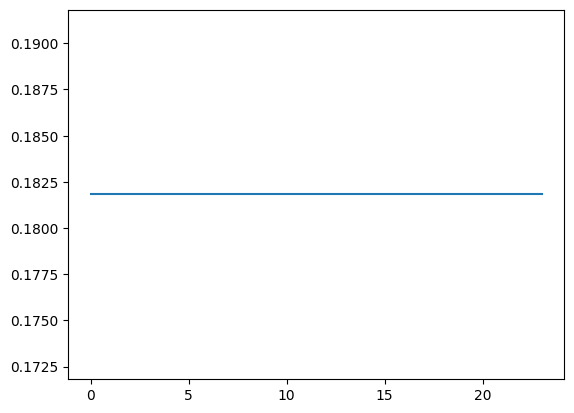

In [189]:
full_density_quasiparticle=np.zeros(len(QPC.couples))
full_density_hf=np.zeros(size_a+size_b)

    

full_density_hf[:size_a]=((nparticles_a-2))/(size_a-1)
full_density_hf[size_a:]=((nparticles_b-2))/(size_b-1)
print(np.sum(full_density_hf))
plt.plot(full_density_hf)
plt.show()

In [ ]:
from scipy.sparse import lil_matrix,identity

hamiltonian_qr_2b_pauliblockade=lil_matrix((QPC2body.quasiparticle_basis.shape[0],QPC2body.rest_basis.shape[0]))

for index_qbasis,qb in enumerate(QPC2body.quasiparticle_basis):
    quasiparticle_indices=[]
    idxs=np.nonzero(qb)[0]
    for idx in idxs:
        quasiparticle_indices.append(QPC2body.couples[idx][0])
        quasiparticle_indices.append(QPC2body.couples[idx][1])
    for index_restbasis,rb in enumerate(QPC2body.rest_basis):
        if hamiltonian_qr_2b[index_qbasis,index_restbasis]!=0.:
            
            rest_indices=np.nonzero(rb)[0]
            added_indices = sorted(set(rest_indices) - set(quasiparticle_indices))  # added
            removed_indices=sorted(set(quasiparticle_indices) - set(rest_indices))
            pauli_blocking_vector_added=((1-full_density_hf[added_indices]))
            pauli_blocking_vector_removed=(full_density_hf[removed_indices])
            
            if len(added_indices)==1:
                constrain=np.prod(pauli_blocking_vector_added)
            
            if len(added_indices)==2:
                constrain=np.prod(pauli_blocking_vector_added)#rho_vacuum[added_indices[0],added_indices[1]]
                print(pauli_blocking_vector_added)
                print(constrain)
            hamiltonian_qr_2b_pauliblockade[index_qbasis,index_restbasis]=constrain*hamiltonian_qr_2b[index_qbasis,index_restbasis]
            #hamiltonian_rq_2b_pauliblockade[index_restbasis,index_qbasis]=np.prod(pauli_blocking_vector_removed)*hamiltonian_rq_2b[index_restbasis,index_qbasis]
            
hamiltonian_rq_2b_pauliblockade=hamiltonian_qr_2b_pauliblockade.T

In [ ]:
print(hamiltonian_rq_2b_pauliblockade)

##### Pauli Blockade for the off diagonal H_rr

In [192]:
from scipy.sparse import lil_matrix,identity

hamiltonian_rr_masked=hamiltonian_rr_2b.copy()

for index_rbasis_a,rba in enumerate(QPC2body.rest_basis):
    quasiparticle_indices=[]
    rest_indices_a=np.nonzero(rba)[0]
    for index_restbasis_b,rbb in enumerate(QPC2body.rest_basis):
        if hamiltonian_rr_2b[index_rbasis_a,index_restbasis_b]!=0 and index_restbasis_b!=index_rbasis_a:
            
            rest_indices_b=np.nonzero(rbb)[0]
            added_indices = sorted(set(rest_indices_b) - set(rest_indices_a))  # added
            removed_indices=sorted(set(rest_indices_a) - set(rest_indices_b))
            pauli_blocking_vector_added=((1-full_density_hf[added_indices]))
            pauli_blocking_vector_removed=(full_density_hf[removed_indices])
            if len(added_indices)==1:
                constrain=np.prod(pauli_blocking_vector_added)
            
            if len(added_indices)==2:
                constrain=np.prod(pauli_blocking_vector_added)#rho_vacuum[added_indices[0],added_indices[1]]
            
            hamiltonian_rr_masked[index_rbasis_a,index_restbasis_b]=constrain*hamiltonian_rr_2b[index_rbasis_a,index_restbasis_b].copy()
            #hamiltonian_rq_2b_pauliblockade[index_restbasis,index_qbasis]=np.prod(pauli_blocking_vector_removed)*hamiltonian_rq_2b[index_restbasis,index_qbasis]
            


#### Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [ ]:
target_eigenvalue=0
nsteps_iteration_bwi=100
delta_e_iteration=200
e_old=200
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq_2b
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq_2b_pauliblockade   # Start with initial term
for i in trange(nsteps_iteration_bwi):
    if i ==1:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_masked
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    if i >1:
        diagonal_rr=hamiltonian_rr_masked
        single_term =diagonal_rr  @ single_term  # Efficient update
        
    if i==0:
        update=(hamiltonian_qr_2b @ single_term)
    else:
        update=(hamiltonian_qr_2b_pauliblockade @ single_term)
    approximations.append(update)
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
#for i in trange(nsteps_iteration):
i=0 # we want to count the number of iterations
while(np.abs(delta_e_iteration)>1e-3):    
    tot_hamiltonian=hamiltonian_qq_2b
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,_=eigsh(hamiltonian_qq_2b+delta_hamiltonian,k=1)
    # compute the energy for this order
    e=values[0]
    # compute the energy difference
    delta_e_iteration=e_old-e.copy()
    # now you can update the old energy
    e_old=e.copy()
    i+=1
    print(f'Iteration {i}: delta_e={delta_e_iteration}, e={e}')
print(e)
    
    
twobody_quasiparticle_effective_interaction={}
for q,base_q in enumerate(QPC2body.quasiparticle_basis):
    for p,base_p in enumerate(QPC2body.quasiparticle_basis):
        a_q,b_q=np.nonzero(base_q)[0]
        a_p,b_p=np.nonzero(base_p)[0]
        q_max=np.max([a_q,b_q])
        q_min=np.min([a_q,b_q])
        p_max=np.max([a_p,b_p])
        p_min=np.min([a_p,b_p])
        

        twobody_quasiparticle_effective_interaction[(a_q,b_q,a_p,b_p)]=delta_hamiltonian[q,p]
        


In [ ]:
for key in twobody_quasiparticle_effective_interaction.keys():
    a,b,c,d=key
    if twobody_quasiparticle_effective_interaction[key]!=0:
        print('key=',key)
        print(twobody_quasiparticle_effective_interaction[key])
        print('\n')

#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [195]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)



We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [196]:
from tqdm import tqdm
tbar=tqdm(enumerate(twobody_quasiparticle_effective_interaction.keys()))
delta_hamiltonian_qq=0.
for _,key in tbar:
     
    a,b,c,d=key
    delta_hamiltonian_qq+=HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*twobody_quasiparticle_effective_interaction[key]
    

1296it [00:00, 3436.63it/s]


#### Now we compute the iteration using this truncation, good luck

In [197]:

# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian_qq=hamiltonian_qq+delta_hamiltonian_qq
values,psiq=eigsh(tot_hamiltonian_qq,k=1)
e=values[0]

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

-90.7733701671845
0.02157724089754529 index= 27


#### Comparison with the exact Brillouin-Wigner method

In [ ]:
from scipy.sparse.linalg import norm
fidelity=np.abs(np.vdot(psiq_orderi,psiq))**2
print(fidelity)

distance_hf=norm(hamiltonian_tot_qq_full_bw- tot_hamiltonian_qq,ord='fro')/norm(hamiltonian_tot_qq_full_bw,ord='fro')

print(distance_hf)

### Analysis of the Results of the Brillouin-Wigner Methods

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data/bw_calculations.pkl', 'rb') as f:
    data = pickle.load(f)


number_of_particles=data['nparticles']
energies_qq=np.asarray(data['energies_qq'])
energies_exact=np.asarray(data['energies_exact'])
energies_fbw=np.asarray(data['energies_fbw'])
energies_truncated_bw=np.asarray(data['energies_truncated_bw'])
energies_hfbw=np.asarray(data['energies_hfbw'])
nparticles=data['nparticles']
history=data['accuracies_fbw']
n_iterations=np.asarray([len(history[i]) for i in range(len(history))])


In [2]:
print(number_of_particles)
titles=['$^{20}$Ne','$^{22}$Ne','$^{24}$Ne','$^{26}$Ne','$^{28}$Ne','$^{24}$Mg','$^{28}$Mg','$^{30}$Mg','$^{32}$Si','$^{32}$S','$^{34}$S','$^{36}$Ar']

[(2, 2), (4, 2), (6, 2), (8, 2), (10, 2), (4, 4), (4, 8), (4, 10), (6, 10), (8, 8), (8, 10), (10, 10)]


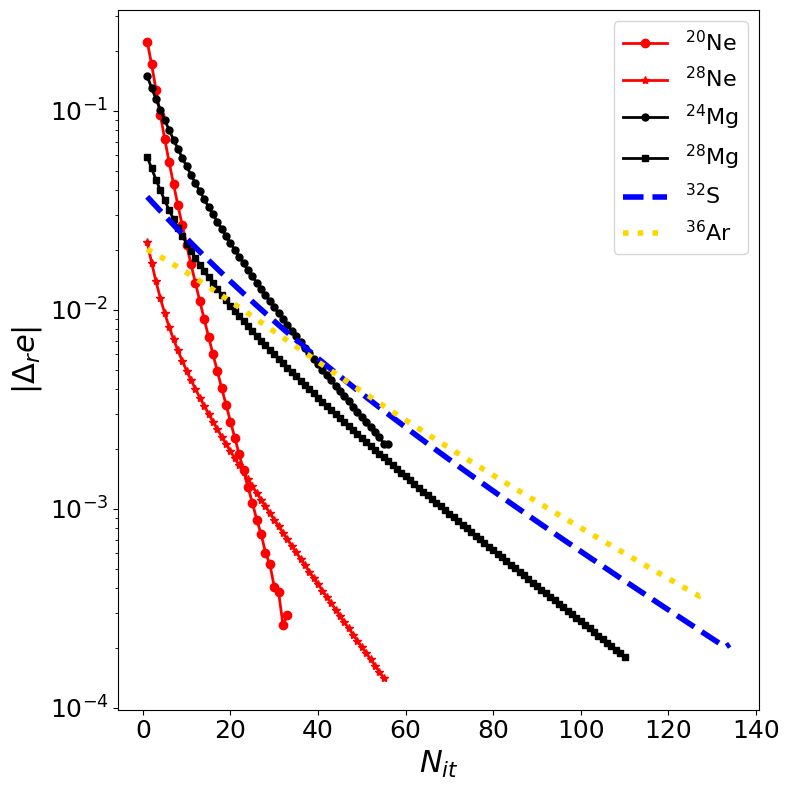

In [3]:
plt.figure(figsize=(8,8))

# Define styles for each nucleus
styles = {
    '$^{20}$Ne': dict(color='red', marker='o', linestyle='-', linewidth=2, markersize=6),
    '$^{28}$Ne': dict(color='red', marker='*', linestyle='-', linewidth=2, markersize=6),
    '$^{24}$Mg': dict(color='black', marker='o', linestyle='-', linewidth=2, markersize=5),
    '$^{28}$Mg': dict(color='black', marker='s', linestyle='-', linewidth=2, markersize=5),
    '$^{32}$S' : dict(color='blue', linestyle='--', linewidth=4),
    '$^{36}$Ar': dict(color='gold', linestyle=':', linewidth=4),
}

for i in range(12):
    label = titles[i]
    
    if label in styles:
        plt.plot(
            range(1, n_iterations[i] + 1),
            history[i],
            label=label,
            **styles[label]
        )

# Axes formatting
plt.yscale('log')
plt.xlabel(r'$N_{it}$', fontsize=22)
plt.ylabel(r'$|\Delta_r e|$', fontsize=22)

plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=14)

plt.legend(fontsize=16, frameon=True)
plt.tight_layout()
plt.show()


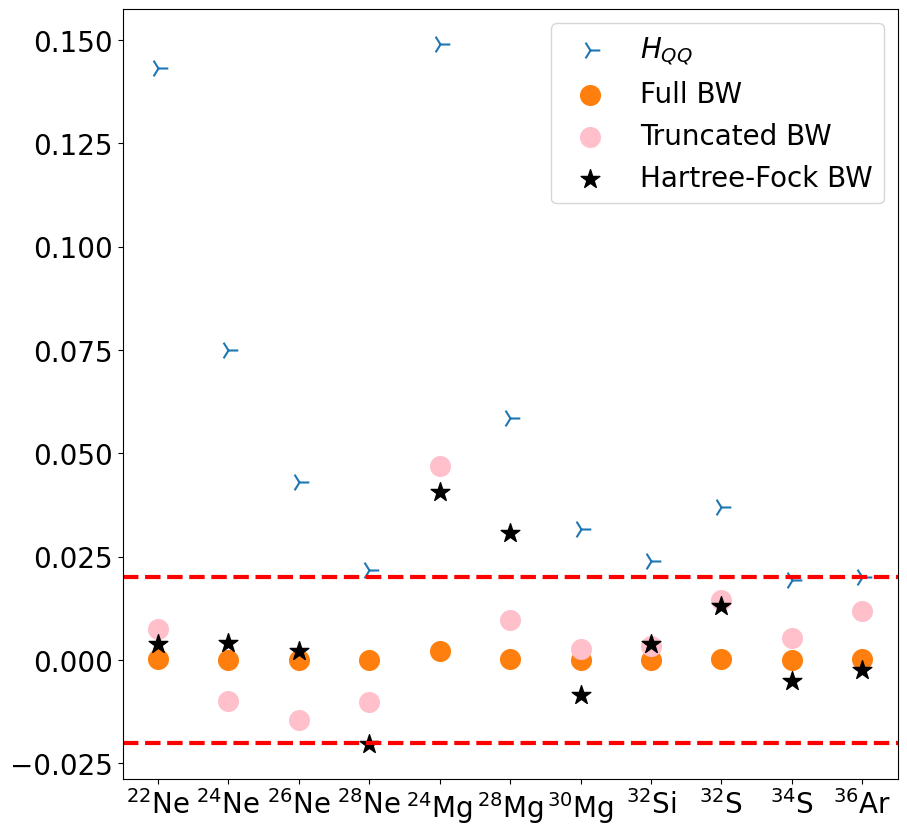

In [4]:
error_qq=(energies_exact[1:]-energies_qq[1:])/energies_exact[1:]
error_fbw=(energies_exact[1:]-energies_fbw[1:])/energies_exact[1:]
error_hfbw=(energies_exact[1:]-energies_hfbw[1:])/energies_exact[1:]
error_truncated_bw=(energies_exact[1:]-energies_truncated_bw[1:])/energies_exact[1:]

points=np.arange(error_qq.shape[0])
plt.figure(figsize=(10,10))
plt.scatter(points,error_qq,label=r'$H_{QQ}$',s=200,marker='4')
plt.scatter(points,error_fbw,label='Full BW',s=200,marker='o')
plt.scatter(points,error_truncated_bw,label='Truncated BW',s=200,marker='o',color='pink')
plt.scatter(points,error_hfbw,label='Hartree-Fock BW',s=200,marker='*',color='black')
plt.axhline(y=0.02,linewidth=3,linestyle='--',color='red')
plt.axhline(y=-0.02,linewidth=3,linestyle='--',color='red')

plt.legend(fontsize=20)
plt.xticks(points,titles[1:])
plt.tick_params(labelsize=20)
plt.show()

Comparison between Iterations and energy error in the full BW method

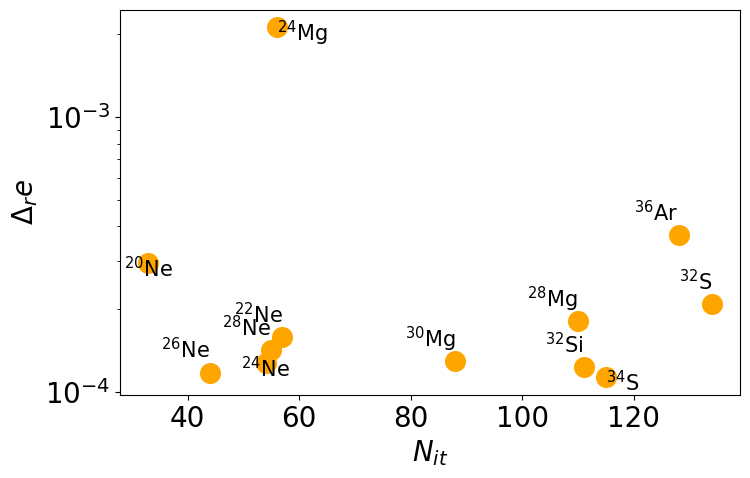

In [5]:
error_fbw=(energies_exact[:]-energies_fbw[:])/energies_exact[:]
scale=1
plt.figure(figsize=(8,5))
plt.scatter(n_iterations/scale,error_fbw,label='Full BW',s=200,marker='o',color='orange')
plt.semilogy()
for i in range(len(n_iterations)):
    #plt.text(n_iterations[i],error_fbw[i],titles[i],fontsize=15,ha='center',va='bottom')
    if titles[i]=='$^{24}$Mg':
        plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,-10), ha='left', fontsize=15)
    elif titles[i]=='$^{20}$Ne':
        plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=15)
    # elif titles[i]=='$^{32}$S':
    #     plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,-10), ha='left', fontsize=15)
    elif titles[i]=='$^{34}$S':
        plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,-10), ha='left', fontsize=15)
    elif titles[i]=='$^{24}$Ne':
        plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=15)
    else:
    
        plt.annotate(titles[i], (n_iterations[i], error_fbw[i]), textcoords="offset points", xytext=(0,10), ha='right', fontsize=15)
plt.tick_params(labelsize=20,which='major')
plt.tick_params(labelsize=15,which='minor')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$\Delta_r e$',fontsize=20)
plt.show()

[np.float64(0.9967938670967016), np.float64(0.9750989589808926), np.float64(0.9762388833359036), np.float64(0.9687069323450025), np.float64(0.9219087494554773), np.float64(0.974991045757412), np.float64(0.9444362553293888), np.float64(0.9161872998866641), np.float64(0.9804306901394595), np.float64(0.7393587025564029), np.float64(0.8876448874454246), np.float64(0.8440554441620132)]
[np.float64(0.4409445329829771), np.float64(0.875539935940525), np.float64(0.892969155542633), np.float64(0.6744972595535609), np.float64(0.8251718328105478), np.float64(0.6655494608942556), np.float64(0.8902288437818167), np.float64(0.9177276323129145), np.float64(0.9744879841414822), np.float64(0.7074060690407644), np.float64(0.9565953023922846), np.float64(0.9428765215182057)]


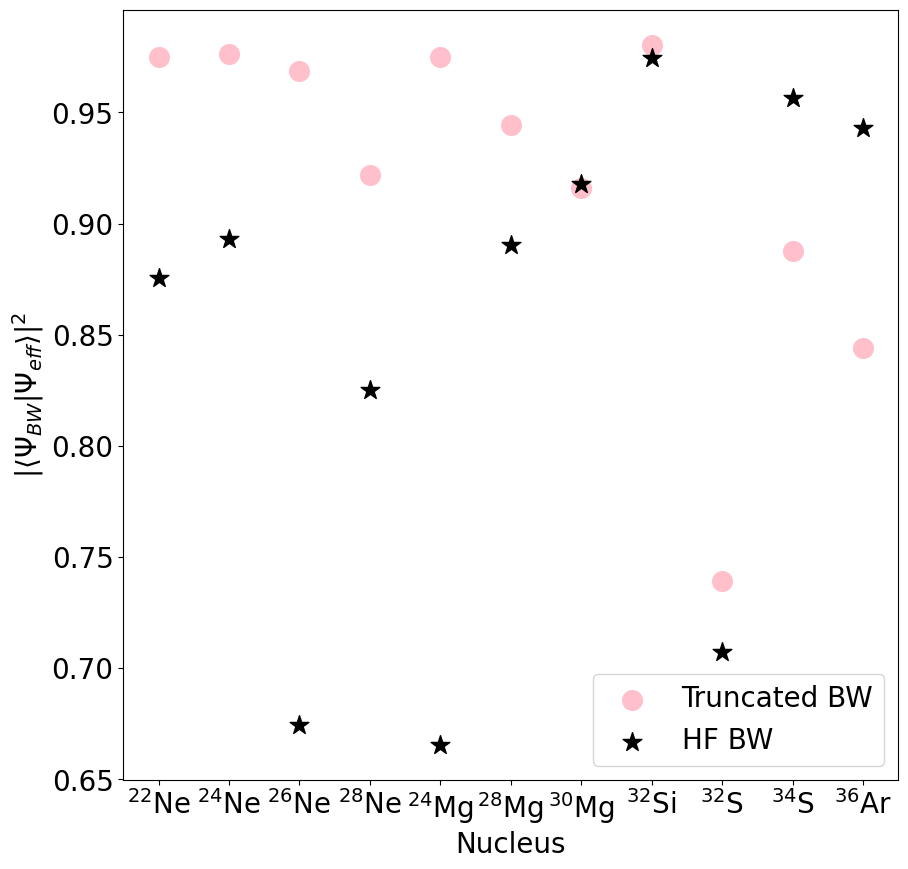

In [7]:
fidelity_hfbw=data['fidelities_hfbw']
fidelity_truncated_bw=data['fidelities_truncated_bw']
print(fidelity_truncated_bw)
print(fidelity_hfbw)

plt.figure(figsize=(10,10))
plt.scatter(points,fidelity_truncated_bw[1:],label='Truncated BW',s=200,color='pink')
plt.scatter(points,fidelity_hfbw[1:],label='HF BW',s=200,marker='*',color='black')
plt.xlabel('Nucleus',fontsize=20)
plt.ylabel(r'$|\langle \Psi_{BW}| \Psi_{eff} \rangle |^2$',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(points,titles[1:])
plt.tick_params(labelsize=20)
plt.show()

##### NEED TO GET THE STATES AND THE HAMILTONIANS TO MEASURE THE ACCURACY OF THE HAMILTONIANS

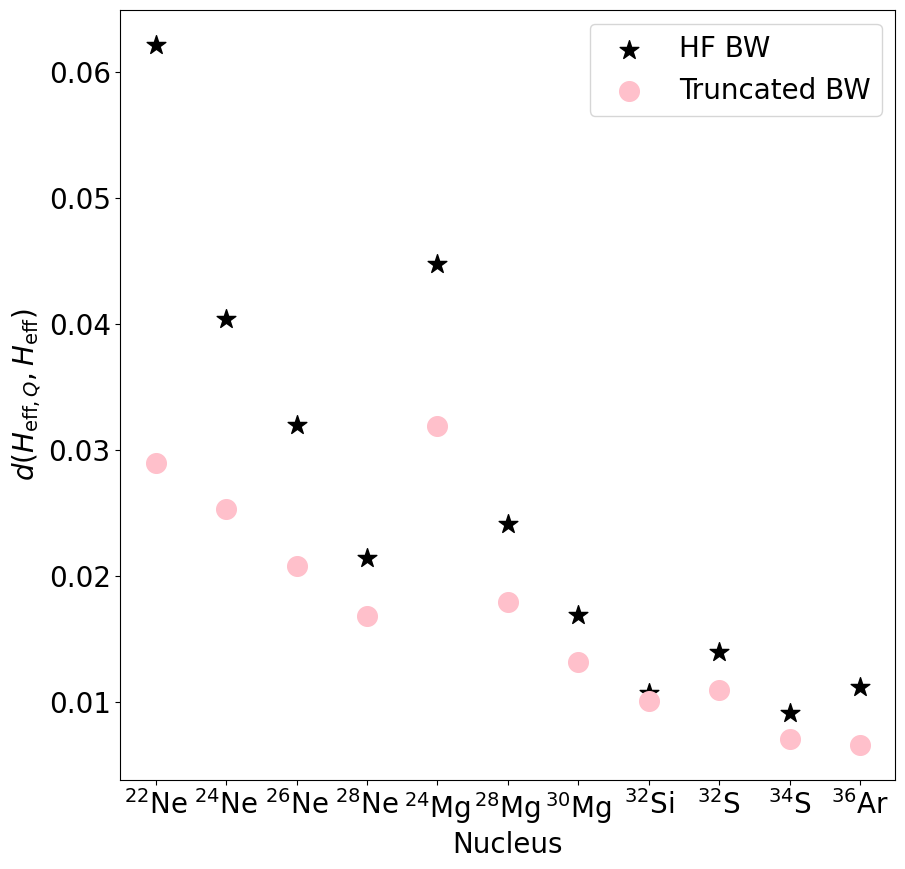

In [10]:
op_fidelity_hfbw=data['operator_fidelities_hfbw']
op_fidelity_truncated_bw=data['operator_fidelities_bw']

plt.figure(figsize=(10,10))
plt.scatter(points,op_fidelity_hfbw[1:],label='HF BW',s=200,marker='*',color='black')
plt.scatter(points,op_fidelity_truncated_bw[1:],label='Truncated BW',s=200,marker='o',color='pink')
plt.xlabel('Nucleus',fontsize=20)
plt.ylabel(r'$d(H_{\mathrm{eff},Q},H_{\mathrm{eff}})$',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(points,titles[1:])
plt.tick_params(labelsize=20)
plt.show()

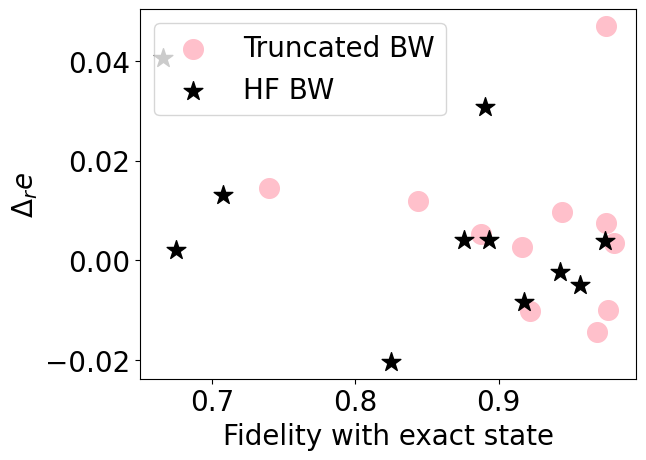

In [11]:
plt.scatter(fidelity_truncated_bw[1:],error_truncated_bw,label='Truncated BW',s=200,marker='o',color='pink')
plt.scatter(fidelity_hfbw[1:],error_hfbw,label='HF BW',s=200,marker='*',color='black')
plt.xlabel(r'Fidelity with exact state',fontsize=20)
plt.ylabel(r'$\Delta_r e$',fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.show()